*  [Classification Analysis on Telco Customer Churn - The Startup - Medium](https://medium.com/swlh/classification-analysis-on-telco-customer-churn-a01599ad28d7)

* IBM sample datasets
https://www.kaggle.com/blastchar/telco-customer-churn

* Demographic info: 
    * Gender, SeniorCitizen, Partner, Dependents
* Services subscribed: 
    * PhoneService, MultipleLine, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
* Customer account info:
    * CustomerID, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Tenure

In [1]:
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

sns.set()
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

## Exploratory Data Analysis

In [2]:
# 파일을 읽어와 df에 담습니다.

# ID 유니크 값
# Partner 파트너 있는지
# Dependents 부양가족 있는지
# Tenure 서비스 얼마나 사용했는지
# MultipleLines 여러 서비스 사용하는지
df = pd.read_csv('data/telco-customer-churn.csv')
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [4]:
# 데이터의 갯수를 봅니다.

df.shape

(7043, 21)

In [6]:
# 컬럼만 출력해 봅니다.

df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
# 전체 데이터의 결측치 수를 봅니다.

df.isnull().sum().sum()

0

In [9]:
# 전체 데이터프레임의 unique 데이터수를 nunique()를 통해 세어봅니다.

df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [10]:
# info를 봅니다.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Missing & Duplicated Value

In [11]:
# 결측치가 있다면 dropna 를 통해 제거합니다. how='all' 옵션을 사용합니다.
# 중복데이터가 있다면 제거합니다.
print(df.shape)
df = df.dropna(how='all') # remove samples with null fields
df = df[~df.duplicated()] # remove duplicates
print(df.shape)

(7043, 21)
(7043, 21)


### 결측치 
* TotalCharges 

In [13]:
# TotalCharges 의 타입을 봅니다.
# 띄어쓰기나 한글은 [""] 형식으로 보아야함
df.TotalCharges.dtypes

dtype('O')

In [15]:
# TotalCharges 가 " " 값으로 들어가 있는 데이터를 찾습니다.
df.loc[df.TotalCharges == ' ', 'TotalCharges'].count()

11

In [16]:
# 공백으로 되어 있는 요금을 결측치로 변경합니다. 
# 그리고 TotalCdropnaharges 라는 컬럼에 원본을 그대로 두고 새로운 컬럼에 값을 담습니다.
# 그리고 dropna(how = 'any') 를 통해 데이터프레임 전체에 결측치가 있는 데이터를 모두 제거 합니다.
# 그리고 타입을 float으로 변경합니다.
# 공백으로 되어 있는 요금을 결측치로 변경합니다. 
df['TotalCdropnaharges'] = df['TotalCharges'].replace(' ', np.nan)
df = df.dropna(how = 'any')
df['TotalCharges'] = df['TotalCharges'].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customerID          7032 non-null   object 
 1   gender              7032 non-null   object 
 2   SeniorCitizen       7032 non-null   int64  
 3   Partner             7032 non-null   object 
 4   Dependents          7032 non-null   object 
 5   tenure              7032 non-null   int64  
 6   PhoneService        7032 non-null   object 
 7   MultipleLines       7032 non-null   object 
 8   InternetService     7032 non-null   object 
 9   OnlineSecurity      7032 non-null   object 
 10  OnlineBackup        7032 non-null   object 
 11  DeviceProtection    7032 non-null   object 
 12  TechSupport         7032 non-null   object 
 13  StreamingTV         7032 non-null   object 
 14  StreamingMovies     7032 non-null   object 
 15  Contract            7032 non-null   object 
 16  Paperl

### 이탈률 계산

In [17]:
# Target variable distribution is not balanced as there are more non-churned than churned users
# value_counts 를 통해 이탈률을 계산합니다.

df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [18]:
# value_counts 를 통해 이탈률의 비율을 계산합니다.

df['Churn'].value_counts(normalize=True)

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64

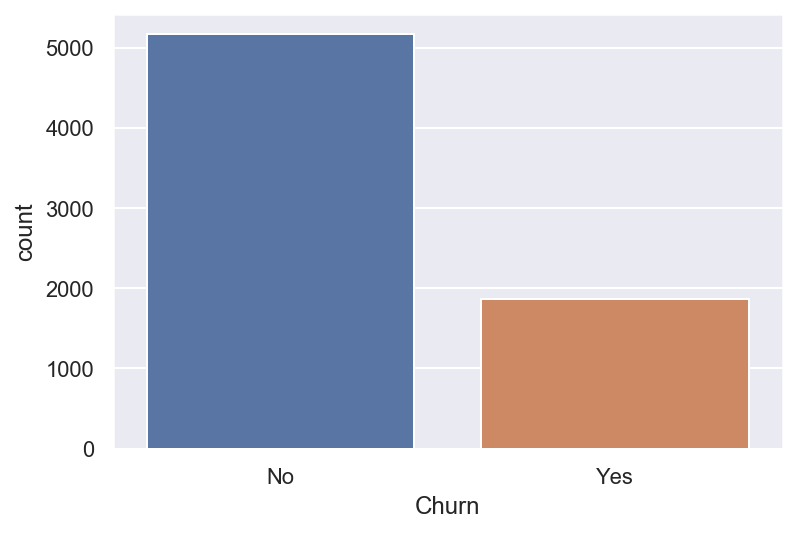

In [19]:
# 이탈률을 시각화 합니다.

sns.countplot(data=df, x='Churn')

In [20]:
# 수치데이터의 요약을 봅니다.

df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7032.000000  7032.000000     7032.000000   7032.000000
mean        0.162400    32.421786       64.798208   2283.300441
std         0.368844    24.545260       30.085974   2266.771362
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.587500    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.862500   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

### 수치형을 범주형으로 바꾸기

In [29]:
# replace values for SeniorCitizen as a categorical feature
# SeniorCitizen 의 값이 1일 때 "Yes"로 0일 때 "No" 로 변경합니다.
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1:'Yes', 0:'No'})

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
df[num_cols].describe()

tenure  MonthlyCharges  TotalCharges
count  7032.000000     7032.000000   7032.000000
mean     32.421786       64.798208   2283.300441
std      24.545260       30.085974   2266.771362
min       1.000000       18.250000     18.800000
25%       9.000000       35.587500    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.862500   3794.737500
max      72.000000      118.750000   8684.800000

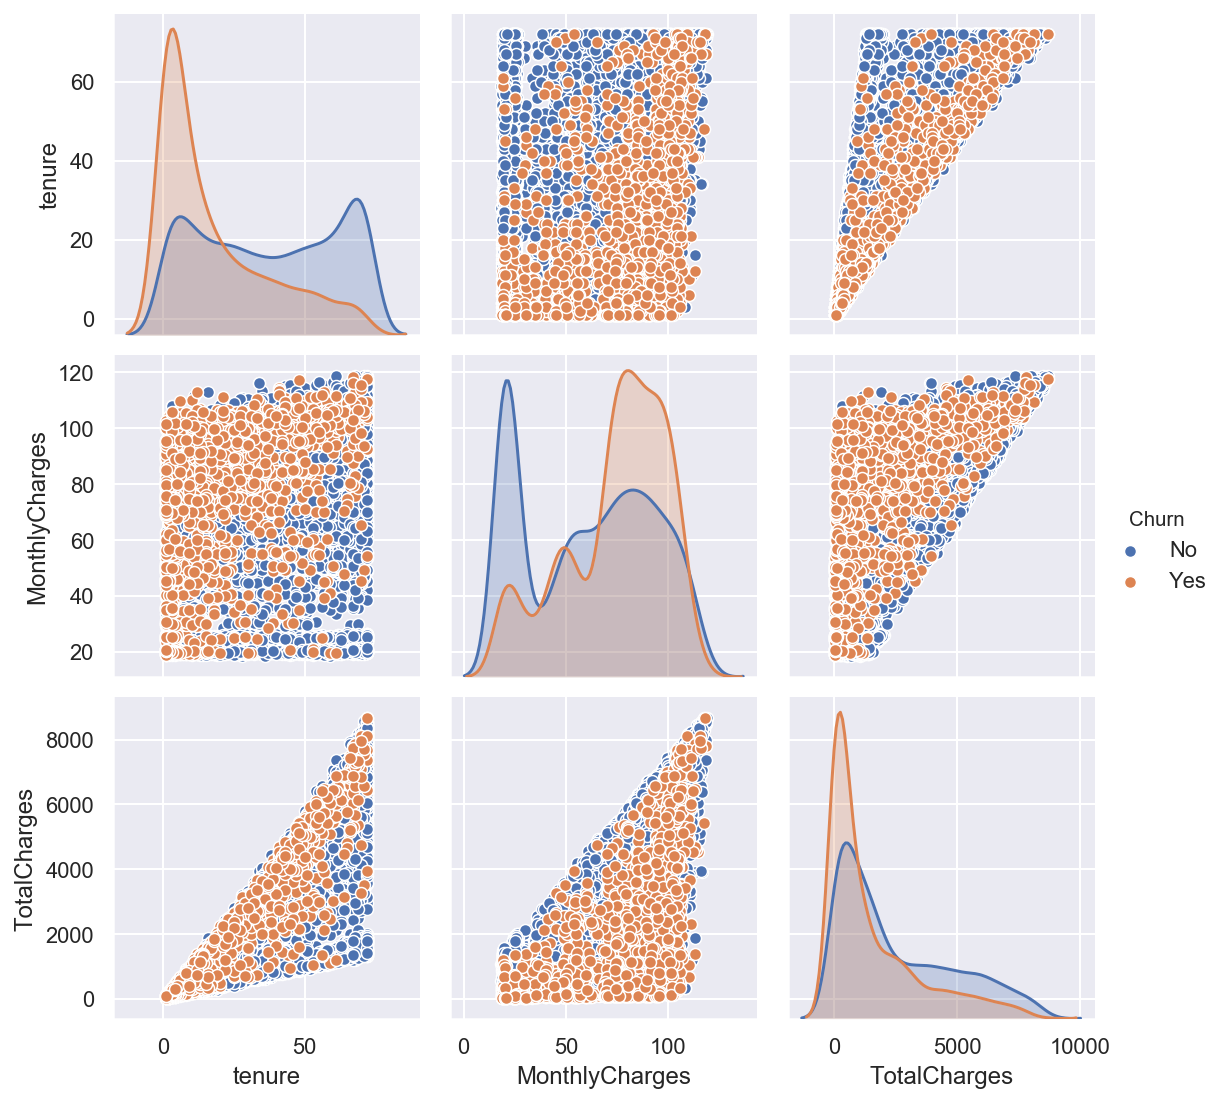

In [30]:
# 'tenure', 'MonthlyCharges', 'TotalCharges' 를 이탈률에 따라 pairplot 으로 그립니다.

sns.pairplot(df[num_cols], hue='Churn')

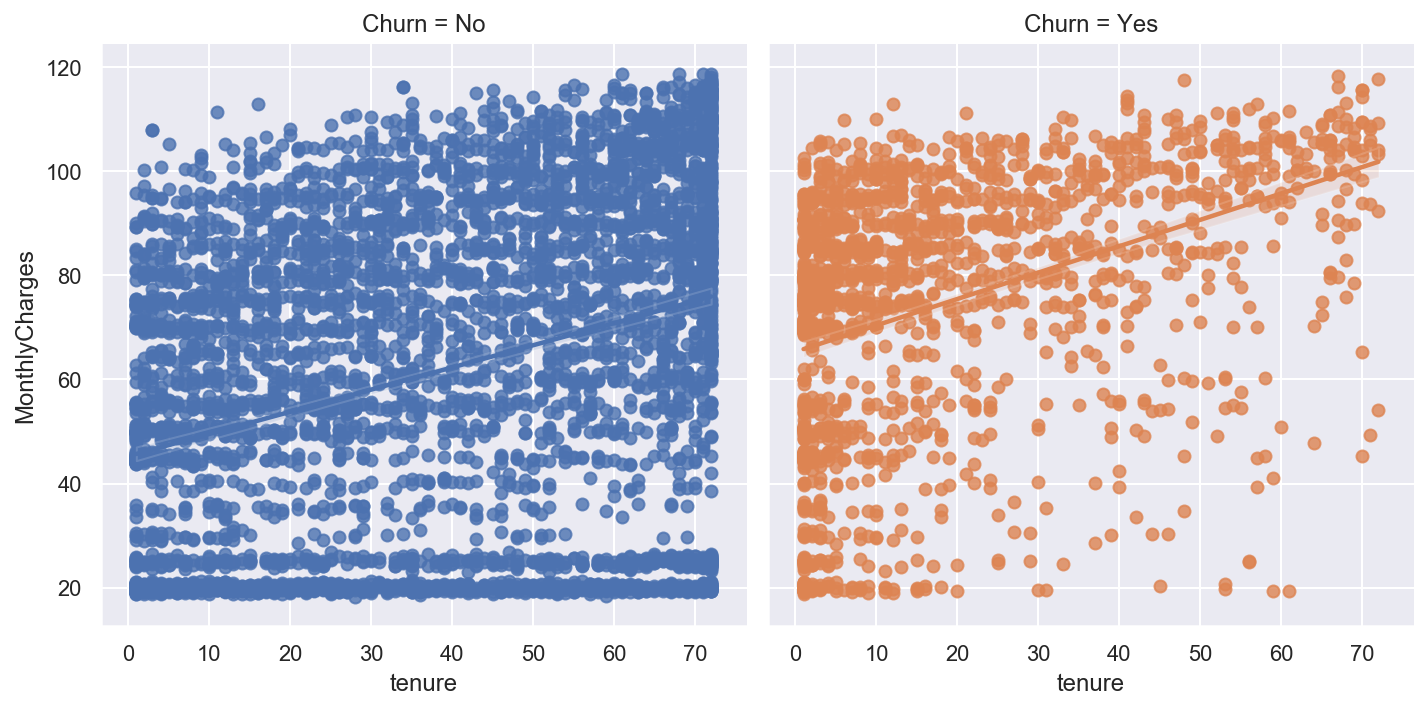

In [28]:
# lmplot 으로 기간(tenure) 에 따른 MonthlyCharges 를 그리고 이탈률별로 나눠 그려봅니다.

sns.lmplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn', col='Churn')

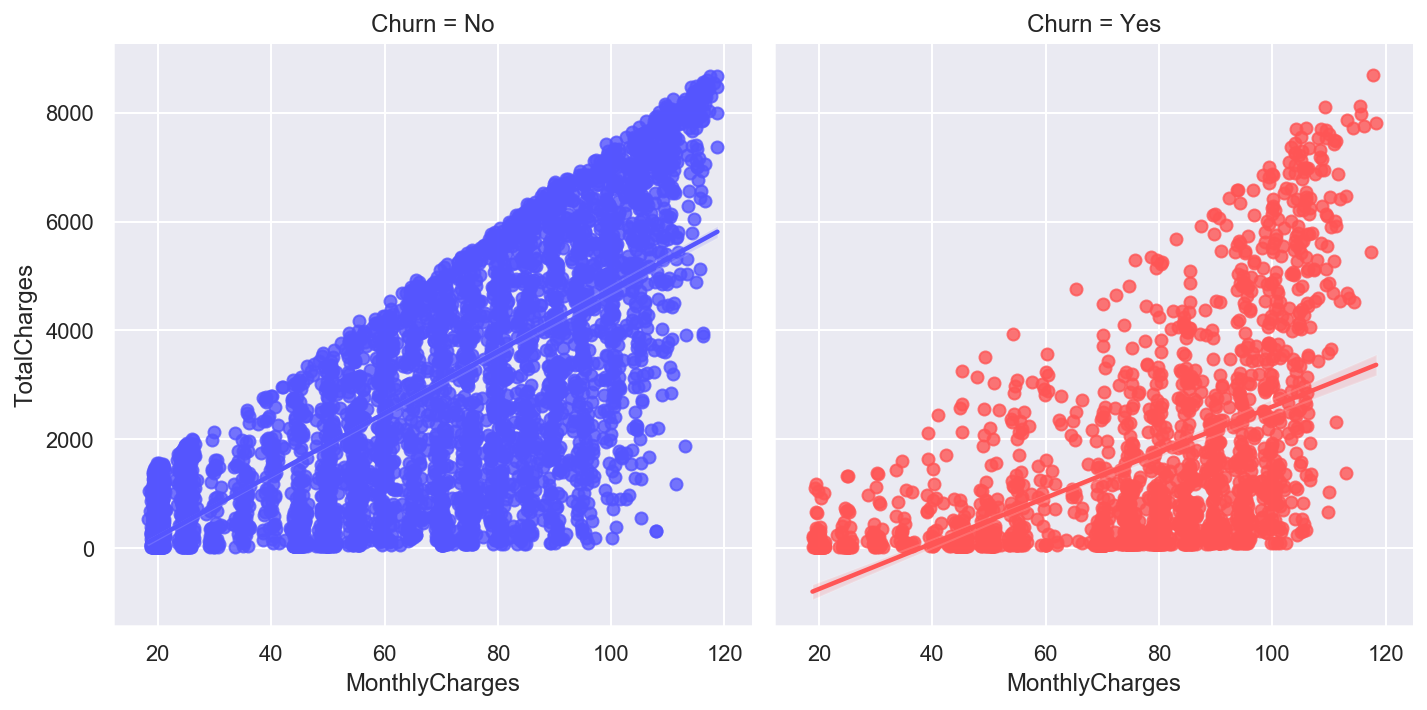

In [32]:
# lmplot 으로 MonthlyCharges 에 따른 TotalCharges 를 그리고 이탈률별로 나눠 그려봅니다.

sns.lmplot(data=df, x='MonthlyCharges', y='TotalCharges',
           hue='Churn', col='Churn',
           palette='seismic')

In [35]:
corr

tenure  MonthlyCharges  TotalCharges
tenure          1.000000        0.246862      0.825880
MonthlyCharges  0.246862        1.000000      0.651065
TotalCharges    0.825880        0.651065      1.000000

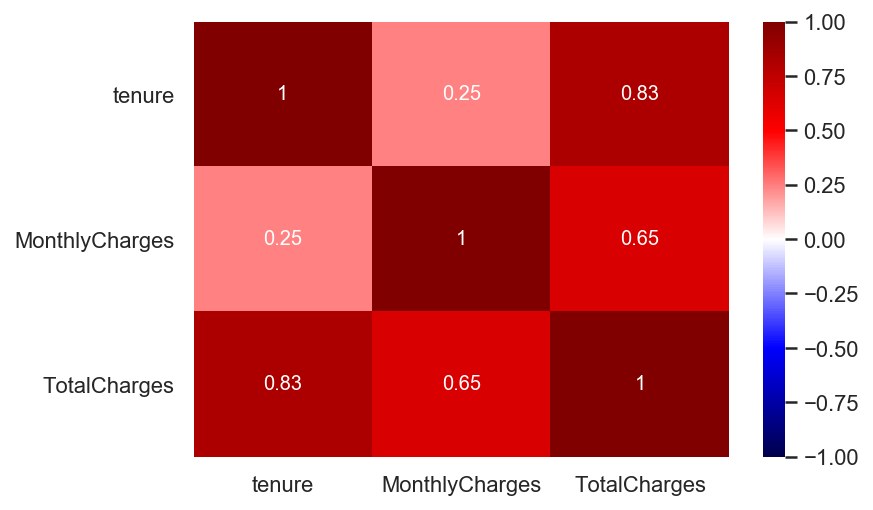

In [36]:
sns.heatmap(corr, cmap='seismic', annot=True, vmax=1, vmin=-1)

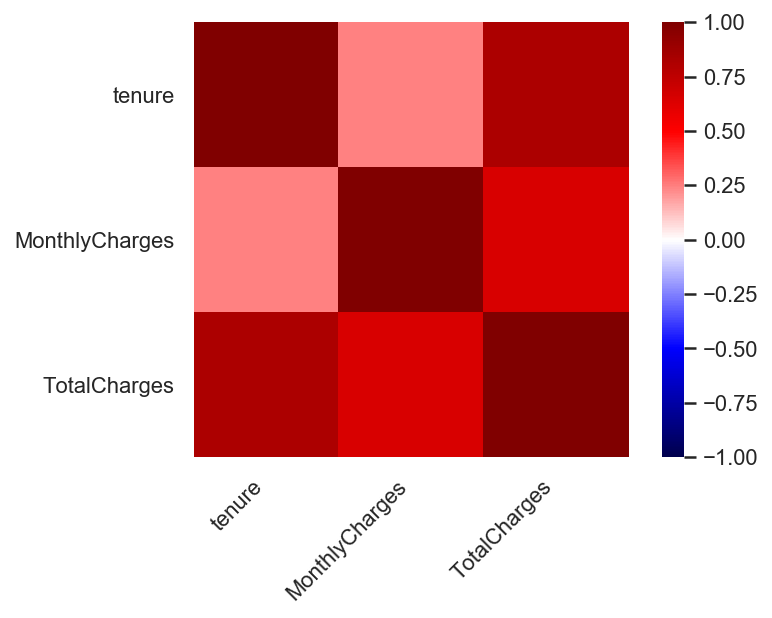

In [33]:
# 수치변수 간의 상관관계를 그려봅니다. 이때 cmap="seismic" 으로 색상을 설정합니다.
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='seismic',
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

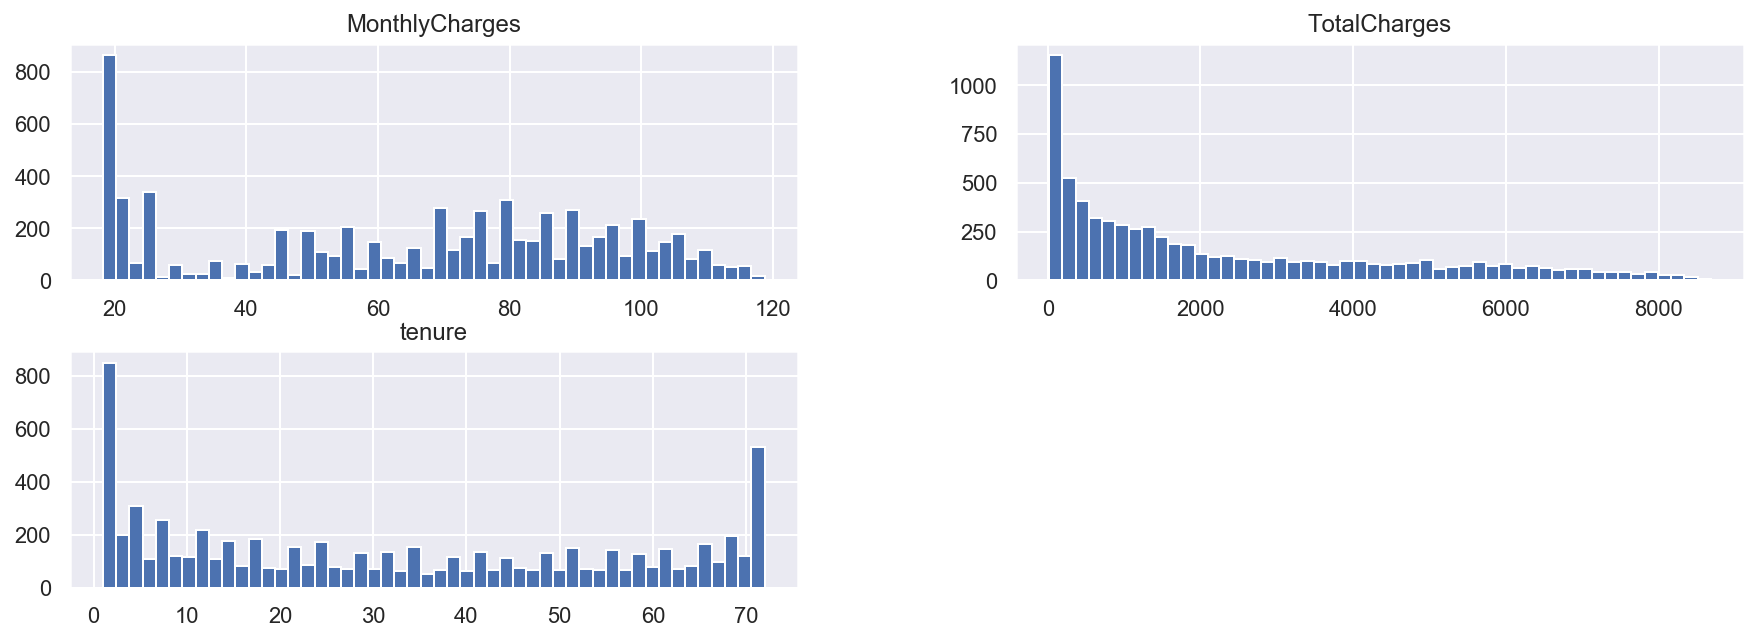

In [38]:
# 수치데이터를 histogram 으로 그려봅니다.

h = df.hist(figsize=(15,5), bins=50)

In [40]:
# object 타입만 가져와 봅니다.

df.dtypes[df.dtypes == 'object']

customerID            object
gender                object
SeniorCitizen         object
Partner               object
Dependents            object
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod         object
Churn                 object
TotalCdropnaharges    object
dtype: object

In [41]:
# To analyse categorical feature distribution
# Note: senior citizens and customers without phone service 
# are minority (less represented) in the data
# Note: "No Internet Service" is a repeated feature in 6 other charts

categorical_features = [
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaymentMethod',
 'PaperlessBilling',
 'Contract' ]
len(categorical_features)

16

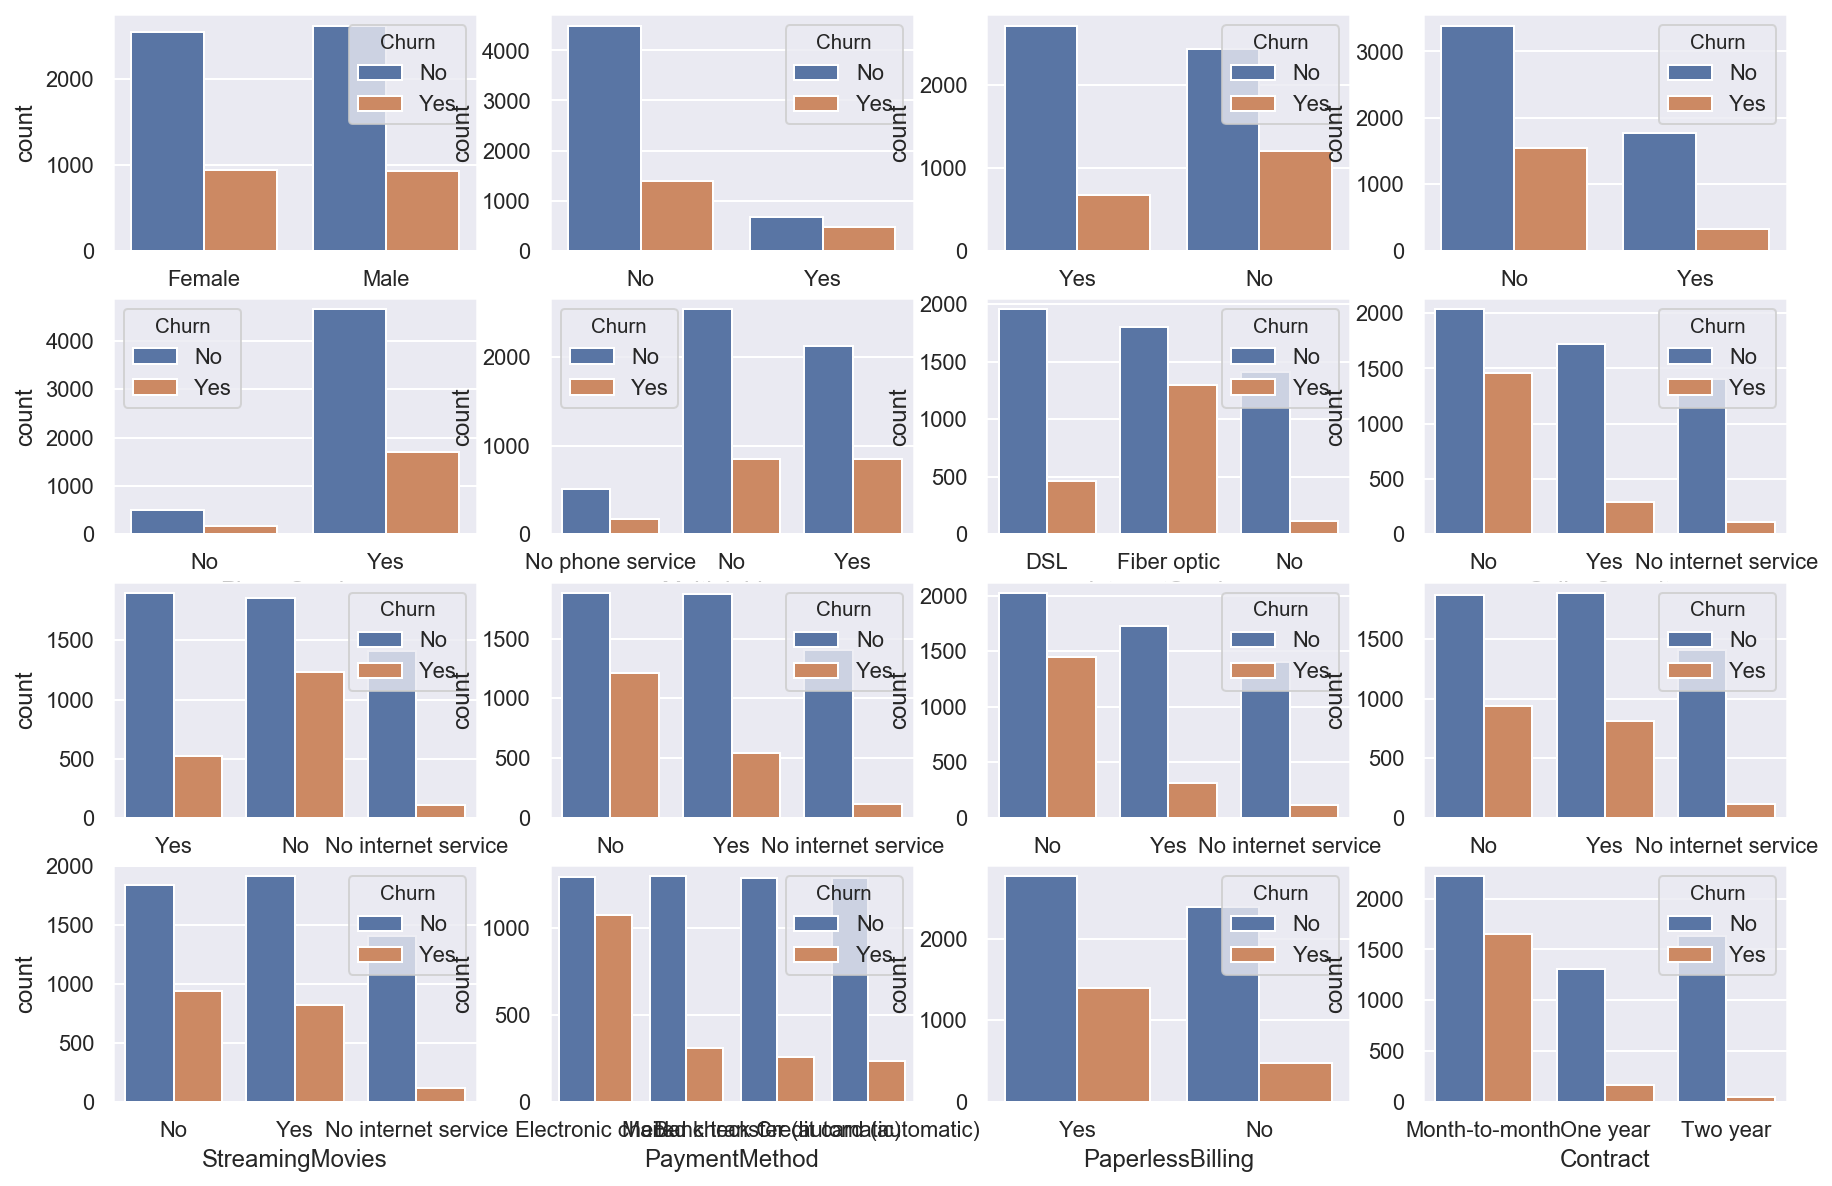

In [55]:
# categorical_features 4 X 4 서브플롯 그리기 

fig, axes = plt.subplots(nrows=4,ncols=4, figsize=(15,10))
# sns.countplot(data=df, x='gender', hue='Churn', ax=axes[0,0])

for i, col_name in enumerate(categorical_features):
    row = i // 4
    col = i % 4
    sns.countplot(data=df, x=col_name, hue='Churn', ax=axes[row, col])

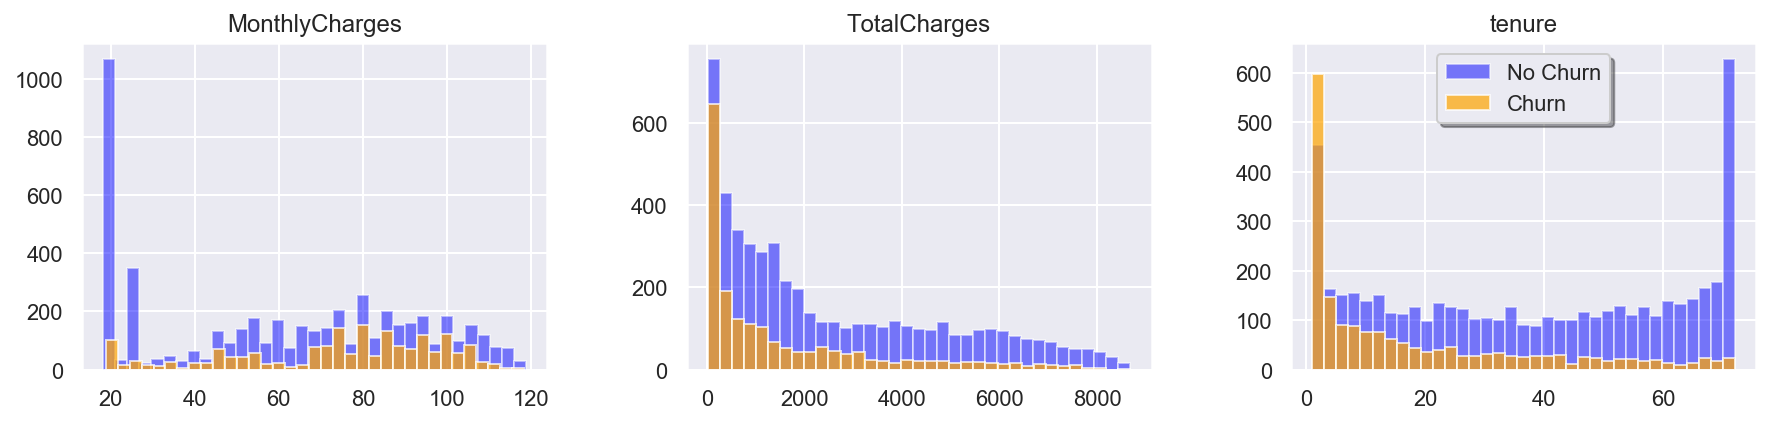

In [56]:
# look at distributions of numerical features in relation to the target variable
# the greater TotalCharges and tenure are the less is the probability of churn

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
df[df.Churn == "No"][num_cols].hist(bins=35, color="blue", alpha=0.5, ax=ax)
df[df.Churn == "Yes"][num_cols].hist(bins=35, color="orange", alpha=0.7, ax=ax)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=9)

## Feature Engineering
### binning(bucketing)
* 연속된 수치데이터를 카테고리 형태의 데이터로 만듭니다.
* 이렇게 카테고리 형태로 만들게 되면 수치데이터를 범주형 데이터로 만들 수가 있습니다.
* 초등학교와 중학교에서 배웠던 도수분포표와 같은 원리 입니다.
* pandas 의 qcut을 활용해서 만들 수도 있지만 단위를 데이터의 특징을 반영해 나눠주려면 직접 범위를 지정해 주는 것이 좋습니다.

In [59]:
# change MonthlyCharges to categorical column
# map은 Series에만 적용할 수 있다.
def monthlycharges_split(df) :   
    if df['MonthlyCharges'] <= 30 :
        return '0-30'
    elif (df['MonthlyCharges'] > 30) & (df['MonthlyCharges'] <= 70 ):
        return '30-70'
    elif (df['MonthlyCharges'] > 70) & (df['MonthlyCharges'] <= 99 ):
        return '70-99'
    elif df['MonthlyCharges'] > 99 :
        return '99plus'
    
df['monthlycharges_group'] = df.apply(monthlycharges_split, axis=1) # monthlycharges_split를 apply로 적용해 주세요.
df[['MonthlyCharges', 'monthlycharges_group']].head()

MonthlyCharges monthlycharges_group
0           29.85                 0-30
1           56.95                30-70
2           53.85                30-70
3           42.30                30-70
4           70.70                70-99

In [62]:
# change TotalCharges to categorical column
def totalcharges_split(df) :   
    if df['TotalCharges'] <= 2000 :
        return '0-2k'
    elif (df['TotalCharges'] > 2000) & (df['TotalCharges'] <= 4000 ):
        return '2k-4k'
    elif (df['TotalCharges'] > 4000) & (df['TotalCharges'] <= 6000) :
        return '4k-6k'
    elif df['TotalCharges'] > 6000 :
        return '6kplus'
    
df['totalcharges_group'] = df.apply(totalcharges_split, axis=1) # totalcharges_split을 apply 로 적용해 주세요.
df[['TotalCharges', 'totalcharges_group']].head(10)

TotalCharges totalcharges_group
0         29.85               0-2k
1       1889.50               0-2k
2        108.15               0-2k
3       1840.75               0-2k
4        151.65               0-2k
5        820.50               0-2k
6       1949.40               0-2k
7        301.90               0-2k
8       3046.05              2k-4k
9       3487.95              2k-4k

In [63]:
# change Tenure to categorical column
def tenure_split(df) :   
    if df['tenure'] <= 20 :
        return '0-20'
    elif (df['tenure'] > 20) & (df['tenure'] <= 40 ):
        return '20-40'
    elif (df['tenure'] > 40) & (df['tenure'] <= 60) :
        return '40-60'
    elif df['tenure'] > 60 :
        return '60plus'
df['tenure_group'] = df.apply(tenure_split, axis=1) # tenure_split 을 apply로 적용해 주세요.

# # Separating categorical and numerical columns
# Id_col     = ['customerID']
# target_col = ['Churn']
# cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
# cat_cols   = [x for x in cat_cols if x not in target_col]
# num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]

# target_col

df[['TotalCharges', 'totalcharges_group', 'tenure', 'tenure_group']].head()

TotalCharges totalcharges_group  tenure tenure_group
0         29.85               0-2k       1         0-20
1       1889.50               0-2k      34        20-40
2        108.15               0-2k       2         0-20
3       1840.75               0-2k      45        40-60
4        151.65               0-2k       2         0-20

In [ ]:
# # Separating categorical and numerical columns
# Id_col     = ['customerID']
# target_col = ['Churn']
# cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
# cat_cols   = [x for x in cat_cols if x not in target_col]
# num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]

# target_col

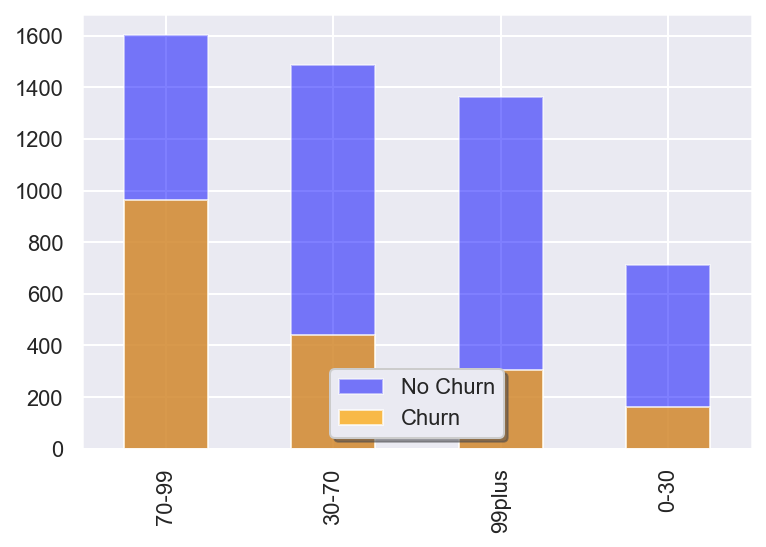

In [69]:
# monthlycharges_group 의 value_counts 를 이탈 여부에 따라 구해봅니다.

df.loc[df.Churn == 'No', 'monthlycharges_group'].value_counts().plot.bar(
    color='blue', alpha=0.5)
df.loc[df.Churn == 'Yes', 'monthlycharges_group'].value_counts().plot.bar(
    color='orange', alpha=0.7)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=8)

### monthlycharges_group

In [ ]:
# new features monthlycharges_group
# monthlycharges_group 에 대한 그래프를 value_counts 로 계산해서 위의 그래프를 참고해서 막대그래프로 그려보세요.
# 이때 이탈률에 따라 다른 색상으로 표시 되게 그립니다.



### totalcharges_group

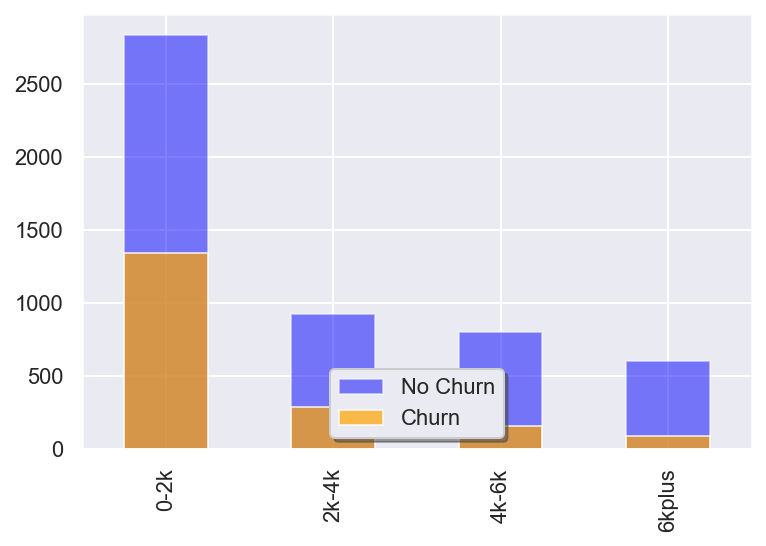

In [70]:
# new features totalcharges_group
# totalcharges_group 도 위와 같은 방법으로 그립니다.


df.loc[df.Churn == 'No', 'totalcharges_group'].value_counts().plot.bar(
    color='blue', alpha=0.5)
df.loc[df.Churn == 'Yes', 'totalcharges_group'].value_counts().plot.bar(
    color='orange', alpha=0.7)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=8)

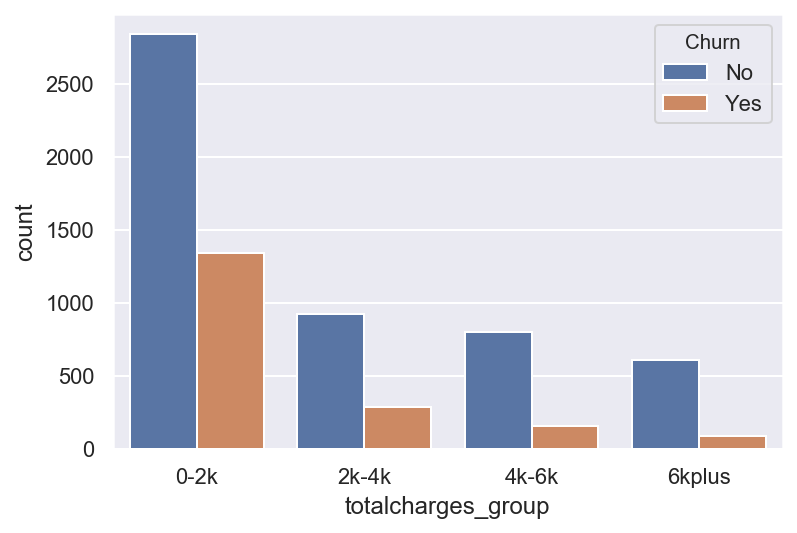

In [71]:
sns.countplot(data=df, x='totalcharges_group', hue='Churn')

### tenure_group

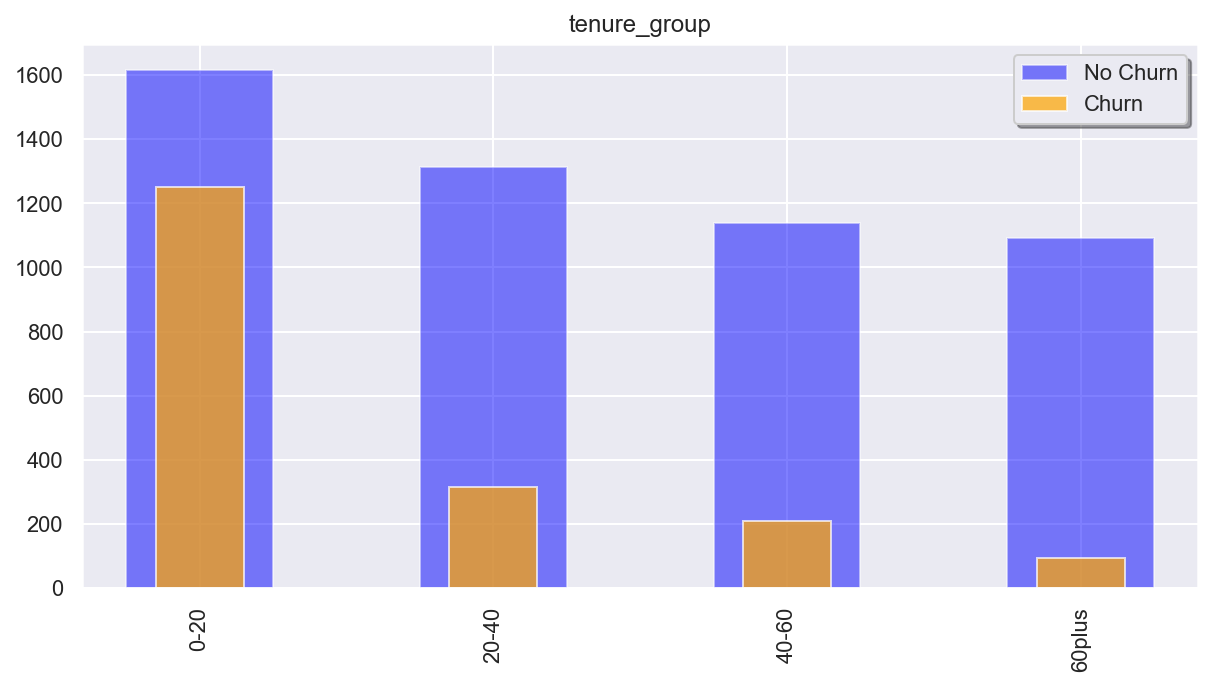

In [72]:
# new features tenure_group
plt.figure(figsize = [10,5])
df[df.Churn == "No"]['tenure_group'].value_counts().plot(
    kind='bar', color="blue", alpha=0.5).set_title('tenure_group')
df[df.Churn == "Yes"]['tenure_group'].value_counts().plot(
    kind='bar', color="orange", alpha=0.7, width=0.3)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=1)

### 전처리 내용을 파일로 저장

In [73]:
# store df to csv file
df.to_csv('df.csv', index=False)

### 저장한 파일 불러오기

In [74]:
df = pd.read_csv('df.csv')

### 범주형 컬럼

In [75]:
# customer id col
Id_col     = ['customerID']
# Target columns
target_col = ['Churn']

In [78]:
df.nunique()[df.nunique()<6].index.tolist()

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'monthlycharges_group',
 'totalcharges_group',
 'tenure_group']

In [80]:
# nunique 값이 6개보다 작다면 범주형 컬럼으로 합니다.
cat_cols   = df.nunique()[df.nunique()<6].index.tolist() # nunique 값이 6개보다 작다면 범주형 컬럼으로 하는 코드를 작성해 주세요.
cat_cols   = [x for x in cat_cols if x not in target_col]
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'monthlycharges_group',
 'totalcharges_group',
 'tenure_group']

### 수치형 컬럼

In [82]:
# 수치형 컬럼 만들기
# 전체 컬럼에서 cat_cols + target_col + Id_col 를 제외합니다.
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalCdropnaharges']

In [84]:
df.nunique()[df.nunique() == 2].index.tolist()

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [85]:
# nunique 값이 2개라면 바이너리 값으로 볼 수 있기 때문에 따로 처리
# 바이너리 컬럼을 찾아주세요. 다음의 값이 나와야 합니다.
# ['gender',
#  'SeniorCitizen',
#  'Partner',
#  'Dependents',
#  'PhoneService',
#  'PaperlessBilling',
#  'Churn']
bin_cols   =  df.nunique()[df.nunique() == 2].index.tolist()
bin_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [88]:
# 범주형 컬럼에서 바이너리 컬럼을 제외합니다.
multi_cols = [x for x in cat_cols if x not in bin_cols] # cat_cols 에서 bin_cols 를 리스트컴프리헨션으로 제거합니다.
multi_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'monthlycharges_group',
 'totalcharges_group',
 'tenure_group']

### LabelEncoder 범주형 데이터를 수치데이터로 변환

In [89]:
# 값이 2개인 바이너리 컬럼을 인코딩
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
df[bin_cols].head()

gender  SeniorCitizen  Partner  Dependents  PhoneService  PaperlessBilling  \
0       0              0        1           0             0                 1   
1       1              0        0           0             1                 0   
2       1              0        0           0             1                 1   
3       1              0        0           0             0                 0   
4       0              0        0           0             1                 1   

   Churn  
0      0  
1      0  
2      1  
3      0  
4      1

In [90]:
df[multi_cols]

MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     No phone service             DSL             No          Yes   
1                   No             DSL            Yes           No   
2                   No             DSL            Yes          Yes   
3     No phone service             DSL            Yes           No   
4                   No     Fiber optic             No           No   
...                ...             ...            ...          ...   
7027               Yes             DSL            Yes           No   
7028               Yes     Fiber optic             No          Yes   
7029  No phone service             DSL            Yes           No   
7030               Yes     Fiber optic             No           No   
7031                No     Fiber optic            Yes           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7027              Yes         Yes         Yes             Yes        One year   
7028              Yes          No         Yes             Yes        One year   
7029               No          No          No              No  Month-to-month   
7030               No          No          No              No  Month-to-month   
7031              Yes         Yes         Yes             Yes        Two year   

                  PaymentMethod monthlycharges_group totalcharges_group  \
0              Electronic check                 0-30               0-2k   
1                  Mailed check                30-70               0-2k   
2                  Mailed check                30-70               0-2k   
3     Bank transfer (automatic)                30-70               0-2k   
4              Electronic check                70-99               0-2k   
...                         ...                  ...                ...   
7027               Mailed check                70-99               0-2k   
7028    Credit card (automatic)               99plus             6kplus   
7029           Electronic check                 0-30               0-2k   
7030               Mailed check                70-99               0-2k   
7031  Bank transfer (automatic)               99plus             6kplus   

     tenure_group  
0            0-20  
1           20-40  
2            0-20  
3           40-60  
4            0-20  
...           ...  
7027        20-40  
7028       60plus  
7029         0-20  
7030         0-20  
7031       60plus  

[7032 rows x 13 columns]

### One Hot Encoding
* 범주형 데이터 => 수치형 데이터로 변환

In [91]:
# 바이너리 데이터를 제외한 범주형 컬럼을 인코딩
# data = df, columns = multi_cols 으로 get_dummies 를 사용해 원핫인코딩 합니다.
df = pd.get_dummies(data=df, columns=multi_cols)
df

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0     7590-VHVEG       0              0        1           0       1   
1     5575-GNVDE       1              0        0           0      34   
2     3668-QPYBK       1              0        0           0       2   
3     7795-CFOCW       1              0        0           0      45   
4     9237-HQITU       0              0        0           0       2   
...          ...     ...            ...      ...         ...     ...   
7027  6840-RESVB       1              0        1           1      24   
7028  2234-XADUH       0              0        1           1      72   
7029  4801-JZAZL       0              0        1           1      11   
7030  8361-LTMKD       1              1        1           0       4   
7031  3186-AJIEK       1              0        0           0      66   

      PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  ...  \
0                0                 1           29.85         29.85  ...   
1                1                 0           56.95       1889.50  ...   
2                1                 1           53.85        108.15  ...   
3                0                 0           42.30       1840.75  ...   
4                1                 1           70.70        151.65  ...   
...            ...               ...             ...           ...  ...   
7027             1                 1           84.80       1990.50  ...   
7028             1                 1          103.20       7362.90  ...   
7029             0                 1           29.60        346.45  ...   
7030             1                 1           74.40        306.60  ...   
7031             1                 1          105.65       6844.50  ...   

      monthlycharges_group_70-99  monthlycharges_group_99plus  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              1                            0   
...                          ...                          ...   
7027                           1                            0   
7028                           0                            1   
7029                           0                            0   
7030                           1                            0   
7031                           0                            1   

      totalcharges_group_0-2k  totalcharges_group_2k-4k  \
0                           1                         0   
1                           1                         0   
2                           1                         0   
3                           1                         0   
4                           1                         0   
...                       ...                       ...   
7027                        1                         0   
7028                        0                         0   
7029                        1                         0   
7030                        1                         0   
7031                        0                         0   

      totalcharges_group_4k-6k  totalcharges_group_6kplus  tenure_group_0-20  \
0                            0                          0                  1   
1                            0                          0                  0   
2                            0                          0                  1   
3                            0                          0                  0   
4                            0                          0                  1   
...                        ...                        ...                ...   
7027                         0                          0                  0   
7028                         0                          1                  0   
7029                         0

### Scaling
* StandardScaler 로 수치 데이터의 값을 조정합니다.

In [92]:
df[num_cols].head()

tenure  MonthlyCharges  TotalCharges  TotalCdropnaharges
0       1           29.85         29.85               29.85
1      34           56.95       1889.50             1889.50
2       2           53.85        108.15              108.15
3      45           42.30       1840.75             1840.75
4       2           70.70        151.65              151.65

In [94]:
# 수치 데이터(num_cols)에 대해 Scaling을 하고 결과를 scaled 에 저장합니다.
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled, columns=num_cols)
scaled.head()

tenure  MonthlyCharges  TotalCharges  TotalCdropnaharges
0 -1.280248       -1.161694     -0.994194           -0.994194
1  0.064303       -0.260878     -0.173740           -0.173740
2 -1.239504       -0.363923     -0.959649           -0.959649
3  0.512486       -0.747850     -0.195248           -0.195248
4 -1.239504        0.196178     -0.940457           -0.940457

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 55 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               7032 non-null   object 
 1   gender                                   7032 non-null   int32  
 2   SeniorCitizen                            7032 non-null   int32  
 3   Partner                                  7032 non-null   int32  
 4   Dependents                               7032 non-null   int32  
 5   tenure                                   7032 non-null   int64  
 6   PhoneService                             7032 non-null   int32  
 7   PaperlessBilling                         7032 non-null   int32  
 8   MonthlyCharges                           7032 non-null   float64
 9   TotalCharges                             7032 non-null   float64
 10  Churn                                    7032 no

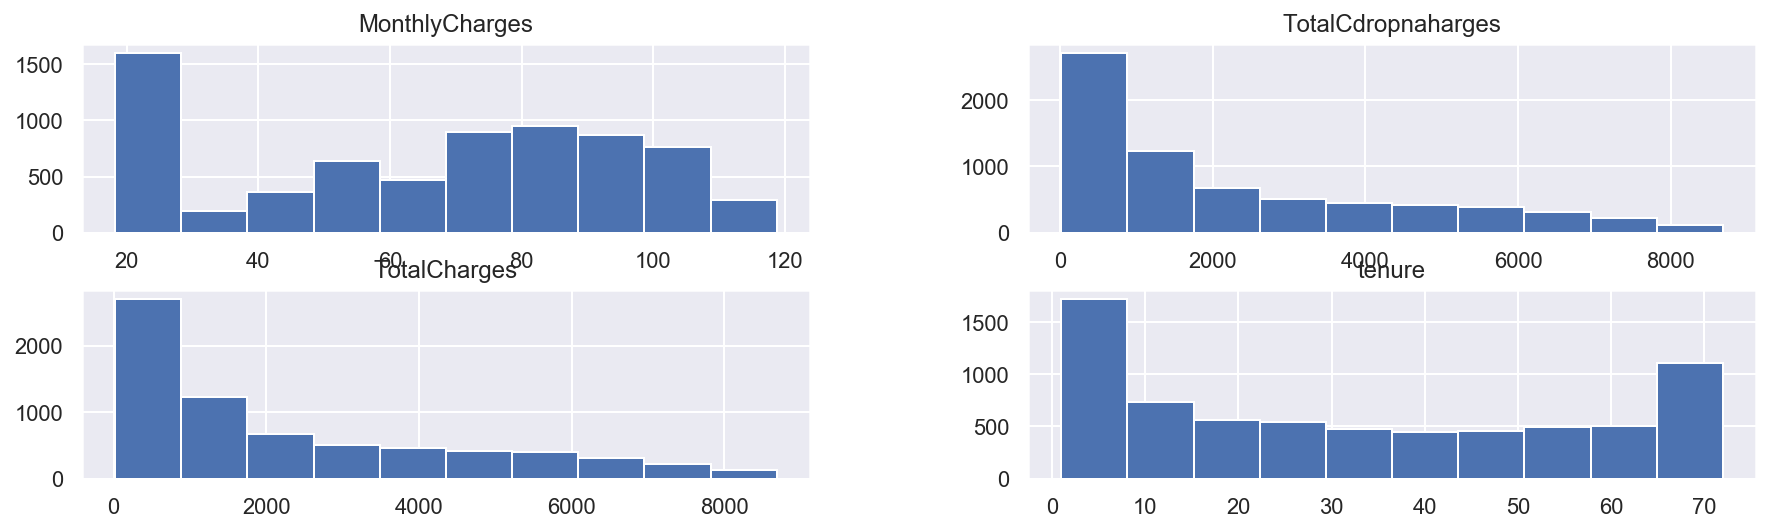

In [95]:
h = df[num_cols].hist(figsize=(15, 4))

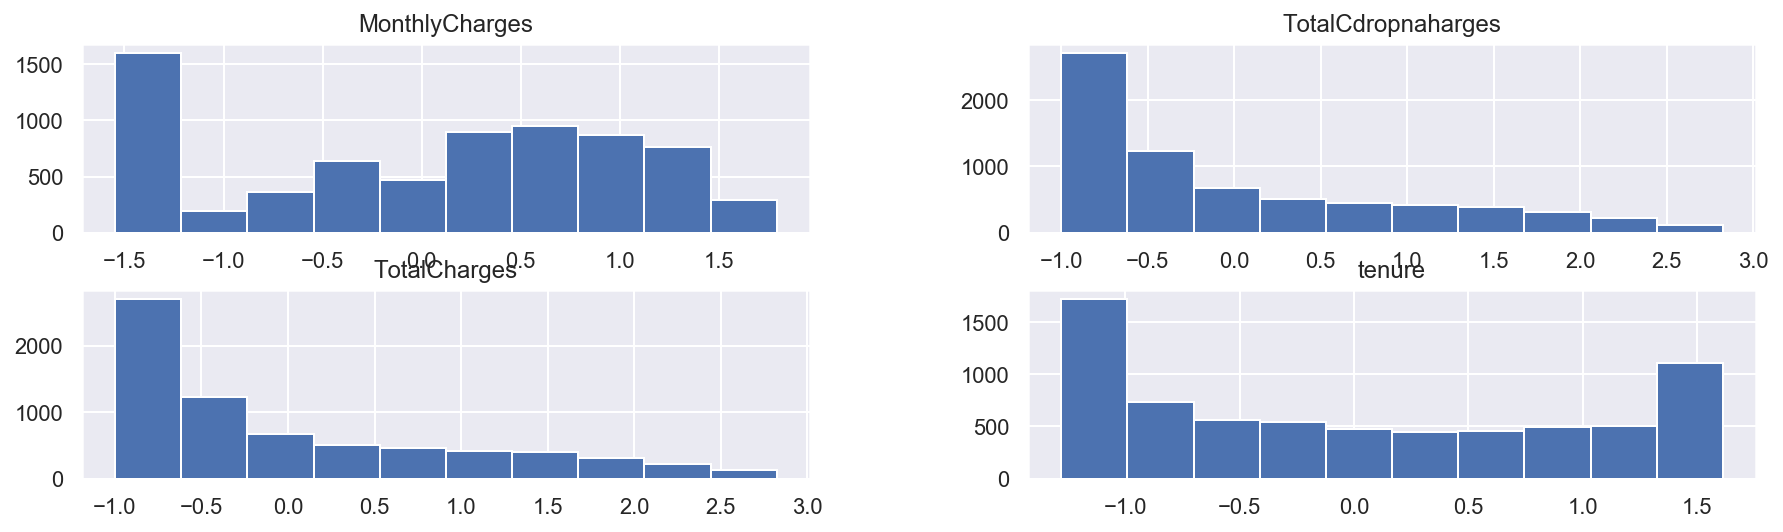

In [96]:
h = scaled.hist(figsize=(15, 4))

### 사용하지 않는 컬럼 제거

In [98]:
# StandardScaler 로 변환한 값을 사용하기 위해 기존 데이터프레임에서 제거하고 
# df1 이라는 새로운 데이터 프레임을 만들어서 변환한 값을 넣어줍니다.

print(df.shape)
df1 = df.drop(columns = num_cols, axis = 1)
df1 = df1.merge(scaled, left_index=True, right_index=True, how = "left")
print(df1.shape)

(7032, 55)
(7032, 55)


In [99]:
# TotalCharges 에 결측치가 있는지 확인합니다.
df1[df1.TotalCharges.isnull()]

Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling, Churn, MultipleLines_No, MultipleLines_No phone service, MultipleLines_Yes, InternetService_DSL, InternetService_Fiber optic, InternetService_No, OnlineSecurity_No, OnlineSecurity_No internet service, OnlineSecurity_Yes, OnlineBackup_No, OnlineBackup_No internet service, OnlineBackup_Yes, DeviceProtection_No, DeviceProtection_No internet service, DeviceProtection_Yes, TechSupport_No, TechSupport_No internet service, TechSupport_Yes, StreamingTV_No, StreamingTV_No internet service, StreamingTV_Yes, StreamingMovies_No, StreamingMovies_No internet service, StreamingMovies_Yes, Contract_Month-to-month, Contract_One year, Contract_Two year, PaymentMethod_Bank transfer (automatic), PaymentMethod_Credit card (automatic), PaymentMethod_Electronic check, PaymentMethod_Mailed check, monthlycharges_group_0-30, monthlycharges_group_30-70, monthlycharges_group_70-99, monthlycharges_group_99plus, totalcharges_group_0-2k, totalcharges_group_2k-4k, totalcharges_group_4k-6k, totalcharges_group_6kplus, tenure_group_0-20, tenure_group_20-40, tenure_group_40-60, tenure_group_60plus, tenure, MonthlyCharges, TotalCharges, TotalCdropnaharges]
Index: []

[0 rows x 55 columns]

In [100]:
df1.describe()

gender  SeniorCitizen      Partner   Dependents  PhoneService  \
count  7032.000000    7032.000000  7032.000000  7032.000000   7032.000000   
mean      0.504693       0.162400     0.482509     0.298493      0.903299   
std       0.500014       0.368844     0.499729     0.457629      0.295571   
min       0.000000       0.000000     0.000000     0.000000      0.000000   
25%       0.000000       0.000000     0.000000     0.000000      1.000000   
50%       1.000000       0.000000     0.000000     0.000000      1.000000   
75%       1.000000       0.000000     1.000000     1.000000      1.000000   
max       1.000000       1.000000     1.000000     1.000000      1.000000   

       PaperlessBilling        Churn  MultipleLines_No  \
count       7032.000000  7032.000000       7032.000000   
mean           0.592719     0.265785          0.481371   
std            0.491363     0.441782          0.499688   
min            0.000000     0.000000          0.000000   
25%            0.000000     0.000000          0.000000   
50%            1.000000     0.000000          0.000000   
75%            1.000000     1.000000          1.000000   
max            1.000000     1.000000          1.000000   

       MultipleLines_No phone service  MultipleLines_Yes  ...  \
count                     7032.000000        7032.000000  ...   
mean                         0.096701           0.421928  ...   
std                          0.295571           0.493902  ...   
min                          0.000000           0.000000  ...   
25%                          0.000000           0.000000  ...   
50%                          0.000000           0.000000  ...   
75%                          0.000000           1.000000  ...   
max                          1.000000           1.000000  ...   

       totalcharges_group_4k-6k  totalcharges_group_6kplus  tenure_group_0-20  \
count                7032.00000                7032.000000        7032.000000   
mean                    0.13595                   0.098407           0.407708   
std                     0.34276                   0.297886           0.491443   
min                     0.00000                   0.000000           0.000000   
25%                     0.00000                   0.000000           0.000000   
50%                     0.00000                   0.000000           0.000000   
75%                     0.00000                   0.000000           1.000000   
max                     1.00000                   1.000000           1.000000   

       tenure_group_20-40  tenure_group_40-60  tenure_group_60plus  \
count         7032.000000         7032.000000          7032.000000   
mean             0.200228            0.191980             0.200085   
std              0.400199            0.393885             0.400092   
min              0.000000            0.000000             0.000000   
25%              0.000000            0.000000             0.000000   
50%              0.000000            0.000000             0.000000   
75%              0.000000            0.000000             0.000000   
max              1.000000            1.000000             1.000000   

             tenure  MonthlyCharges  TotalCharges  TotalCdropnaharges  
count  7.032000e+03    7.032000e+03  7.032000e+03        7.032000e+03  
mean  -1.214741e-16    9.652878e-17 -1.172113e-16       -1.172113e-16  
std    1.000071e+00    1.000071e+00  1.000071e+00        1.000071e+00  
min   -1.280248e+00   -1.547283e+00 -9.990692e-01       -9.990692e-01  
25%   -9.542963e-01   -9.709769e-01 -8.302488e-01       -8.302488e-01  
50%   -1.394171e-01    1.845440e-01 -3.908151e-01       -3.908151e-01  
75%    9.199259e-01    8.331482e-01  6.668271e-01        6.668271e-01  
max    1.612573e+00    1.793381e+00  2.824261e+00        2.824261e+00  

[8 rows x 54 columns]

In [101]:
df1.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'PaperlessBilling', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'P

In [102]:
df1.dtypes

customerID                                  object
gender                                       int32
SeniorCitizen                                int32
Partner                                      int32
Dependents                                   int32
PhoneService                                 int32
PaperlessBilling                             int32
Churn                                        int32
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet service           uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                              uint8
OnlineBackup_No internet service             uint8
OnlineBackup_Yes               

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 55 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               7032 non-null   object 
 1   gender                                   7032 non-null   int32  
 2   SeniorCitizen                            7032 non-null   int32  
 3   Partner                                  7032 non-null   int32  
 4   Dependents                               7032 non-null   int32  
 5   tenure                                   7032 non-null   int64  
 6   PhoneService                             7032 non-null   int32  
 7   PaperlessBilling                         7032 non-null   int32  
 8   MonthlyCharges                           7032 non-null   float64
 9   TotalCharges                             7032 non-null   float64
 10  Churn                                    7032 no

### 상관계수 보기

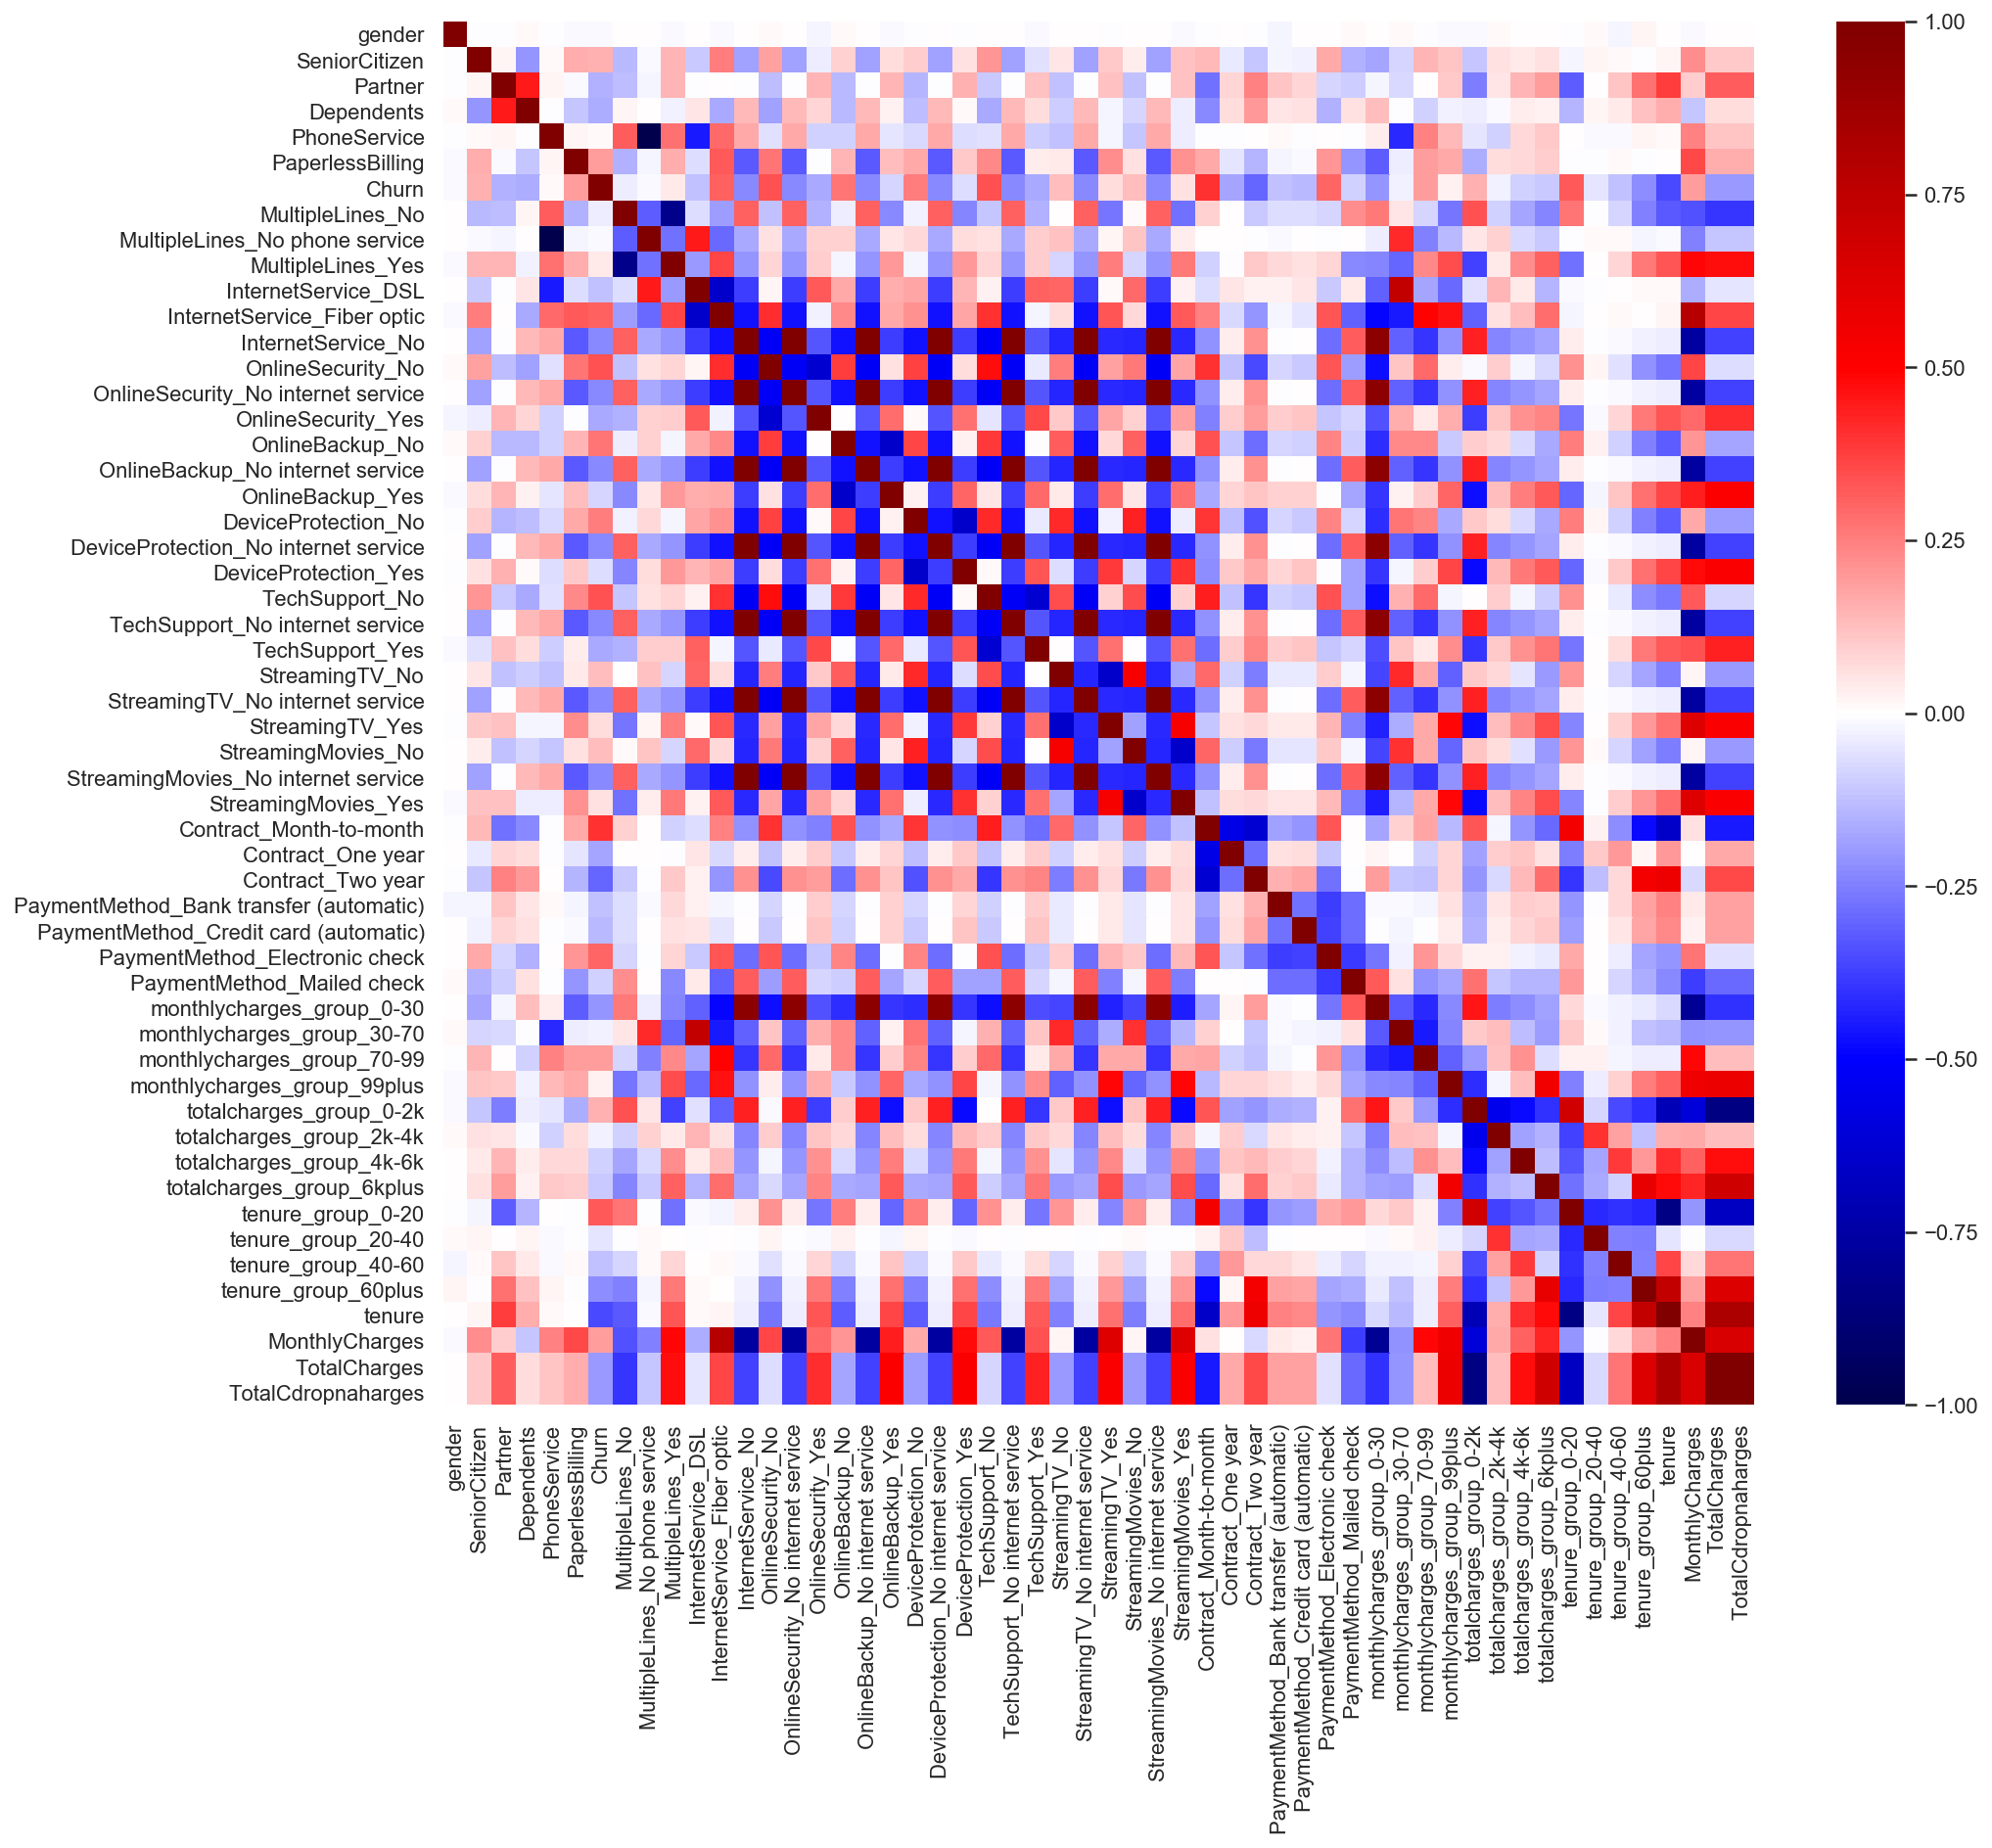

In [104]:
# Correlation Matrix for variables
sns.set(rc={'figure.figsize':(15,13)})
sns.heatmap(df1.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)

In [105]:
# drop 'customerID' column, feature not needed in model selection
df1 = df1.drop('customerID', axis=1)

# there are a lot of repeated features (no internet service), so drop them
df1 = df1.drop(columns=['OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 
                        'DeviceProtection_No internet service', 'TechSupport_No internet service', 
                        'StreamingTV_No internet service', 'StreamingMovies_No internet service'], axis=1)

# original 54 columns, reduced to 47 columns

In [106]:
df1.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'monthlycharges_group_0-30', 'monthlycharges_group_30-70',
       'monthlycharges_group_70-99', 'monthlycharges_group_99plus',
       'totalcharges_group_0-2k', 'totalcharges_group_2k-4k',
       

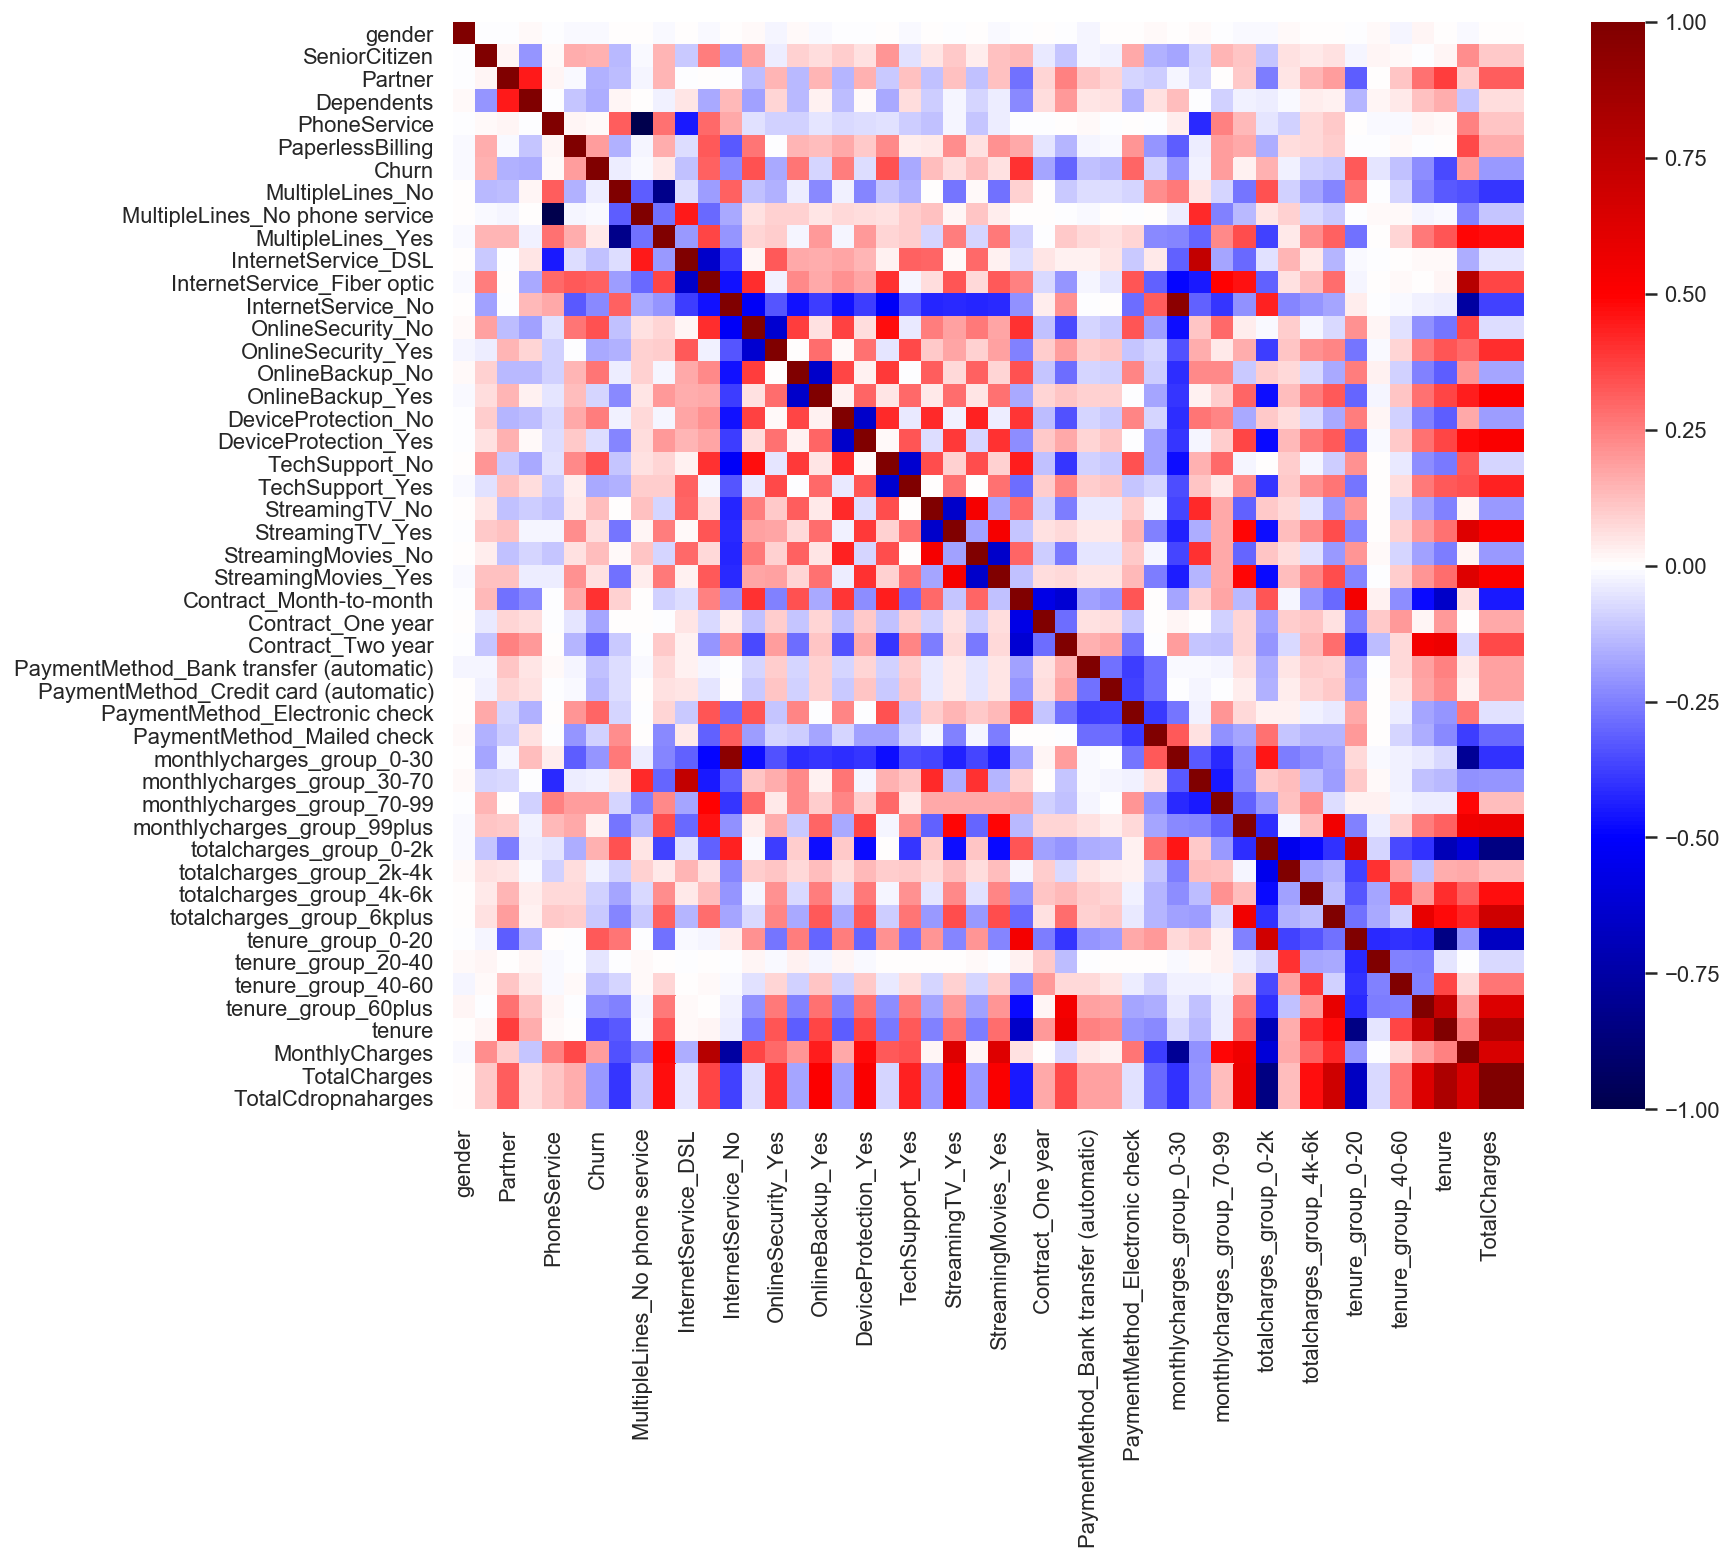

In [107]:
# Correlation Matrix for variables
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(df1.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)

In [108]:
# store df1 to csv file
df1.to_csv('df1.csv', index=False)

## Feature Selection

In [109]:
df1 = pd.read_csv('df1.csv')

In [110]:
X, y = df1.drop('Churn',axis=1), df1['Churn']

import statsmodels.api as sm
X = sm.add_constant(X)  # need to add this to define the Intercept
# model / fit / summarize results
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Churn   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     92.94
Date:                Tue, 14 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:17:56   Log-Likelihood:                -2987.7
No. Observations:                7032   AIC:                             6041.
Df Residuals:                    6999   BIC:                             6268.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.0244      0.051      0.479      0.632      -0.076       0.124
gender                                     -0.0042      0.009     -0.478      0.633      -0.022       0.013
SeniorCitizen                               0.0462      0.013      3.582      0.000       0.021       0.071
Partner                                     0.0032      0.011      0.295      0.768      -0.018       0.024
Dependents                                 -0.0169      0.011     -1.487      0.137      -0.039       0.005
PhoneService                                0.0256      0.020      1.281      0.200      -0.014       0.065
PaperlessBilling                            0.0432      0.010      4.365      0.000       0.024       0.063
MultipleLines_No                           -0.0205      0.006     -3.386      0.001      -0.032      -0.009
MultipleLines_No phone service             -0.0012      0.070     -0.018      0.986      -0.139       0.136
MultipleLines_Yes                           0.0461      0.021      2.157      0.031       0.004       0.088
InternetService_DSL                        -0.0639      0.033     -1.947      0.052      -0.128       0.000
InternetService_Fiber optic                 0.1441      0.076      1.886      0.059      -0.006       0.294
InternetService_No                         -0.0557      0.095     -0.584      0.559      -0.243       0.131
OnlineSecurity_No                           0.0578      0.013      4.442      0.000       0.032       0.083
OnlineSecurity_Yes                          0.0223      0.034      0.662      0.508      -0.044       0.088
OnlineBackup_No                             0.0451      0.013      3.491      0.000       0.020       0.070
OnlineBackup_Yes                            0.0350      0.034      1.042      0.297      -0.031       0.101
DeviceProtection_No                         0.0367      0.013      2.825      0.005       0.011       0.062
DeviceProtection_Yes                        0.0434      0.034      1.290      0.197      -0.023       0.109
TechSupport_No                              0.0582      0.013      4.441      0.000       0.033       0.084
TechSupport_Yes                             0.0219      0.034      0.651      0.515      -0.044       0.088
StreamingTV_No                              0.0065      0.007      0.965      0.335      -0.007       0.020
StreamingTV_Yes                             0.0736      0.044      1.666      0.096      -0.013       0.160
StreamingMovies_No                          0.0072      0.007      1.070      0.285      -0.006       0.020
StreamingMovies_Yes                         0.0729      0.044      1.650      0.099      -0.014       0.160
Contract_Month-to-month                     0.0727      0.0

# 머신러닝으로 예측하기
## 사용할 도구 가져오기

In [111]:
from sklearn.model_selection import KFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn import metricsb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

### StandardScaler로 Scaling

In [112]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

print('Use LassoCV to find the optimal ALPHA value for L1 regularization')
# Scale the Predictors on both the train and validation set
std = StandardScaler()
std.fit(X.values)
X_scaled = std.transform(X.values)
print('X_scaled', X_scaled.shape)

Use LassoCV to find the optimal ALPHA value for L1 regularization
X_scaled (7032, 48)


In [113]:
X_scaled[:5]

array([[ 0.        , -1.00943013, -0.44032709,  1.03561683, -0.65230493,
        -3.05633383,  0.82893915, -0.96341068,  3.05633383, -0.85433559,
         1.38224311, -0.88689648, -0.52513044,  1.00541855, -0.63374636,
        -0.88459567,  1.37833008,  1.12817819, -0.72391796,  1.01259351,
        -0.63926039,  1.22612478, -0.79018582,  1.23636032, -0.79684918,
         0.9026127 , -0.51453688, -0.56136439, -0.52997577, -0.5253508 ,
         1.40476387, -0.54360352,  1.80819829, -0.58742236, -0.75846478,
        -0.4102443 ,  0.82698733, -0.4554312 , -0.39666151, -0.33037594,
         1.20529584, -0.50035549, -0.48743451, -0.50013332, -1.28024804,
        -1.16169394, -0.99419409, -0.99419409],
       [ 0.        ,  0.99065797, -0.44032709, -0.9656081 , -0.65230493,
         0.32718939, -1.20636117,  1.03797895, -0.32718939, -0.85433559,
         1.38224311, -0.88689648, -0.52513044, -0.99461065,  1.57791834,
         1.13045997, -0.72551562, -0.8863848 ,  1.38137199,  1.01259351,
   

### LassoCV 로 피처의 결정계수 찾기

In [115]:
# linspace 는 (시작, 끝, 갯수)로 정의하며 지정한 숫자만큼 값을 나눠 값을 생성합니다.
# l1 맨하탄, l2 유클리디안, ElasticNet은 2개 다
np.linspace(-3, 3, 10)

array([-3.        , -2.33333333, -1.66666667, -1.        , -0.33333333,
        0.33333333,  1.        ,  1.66666667,  2.33333333,  3.        ])

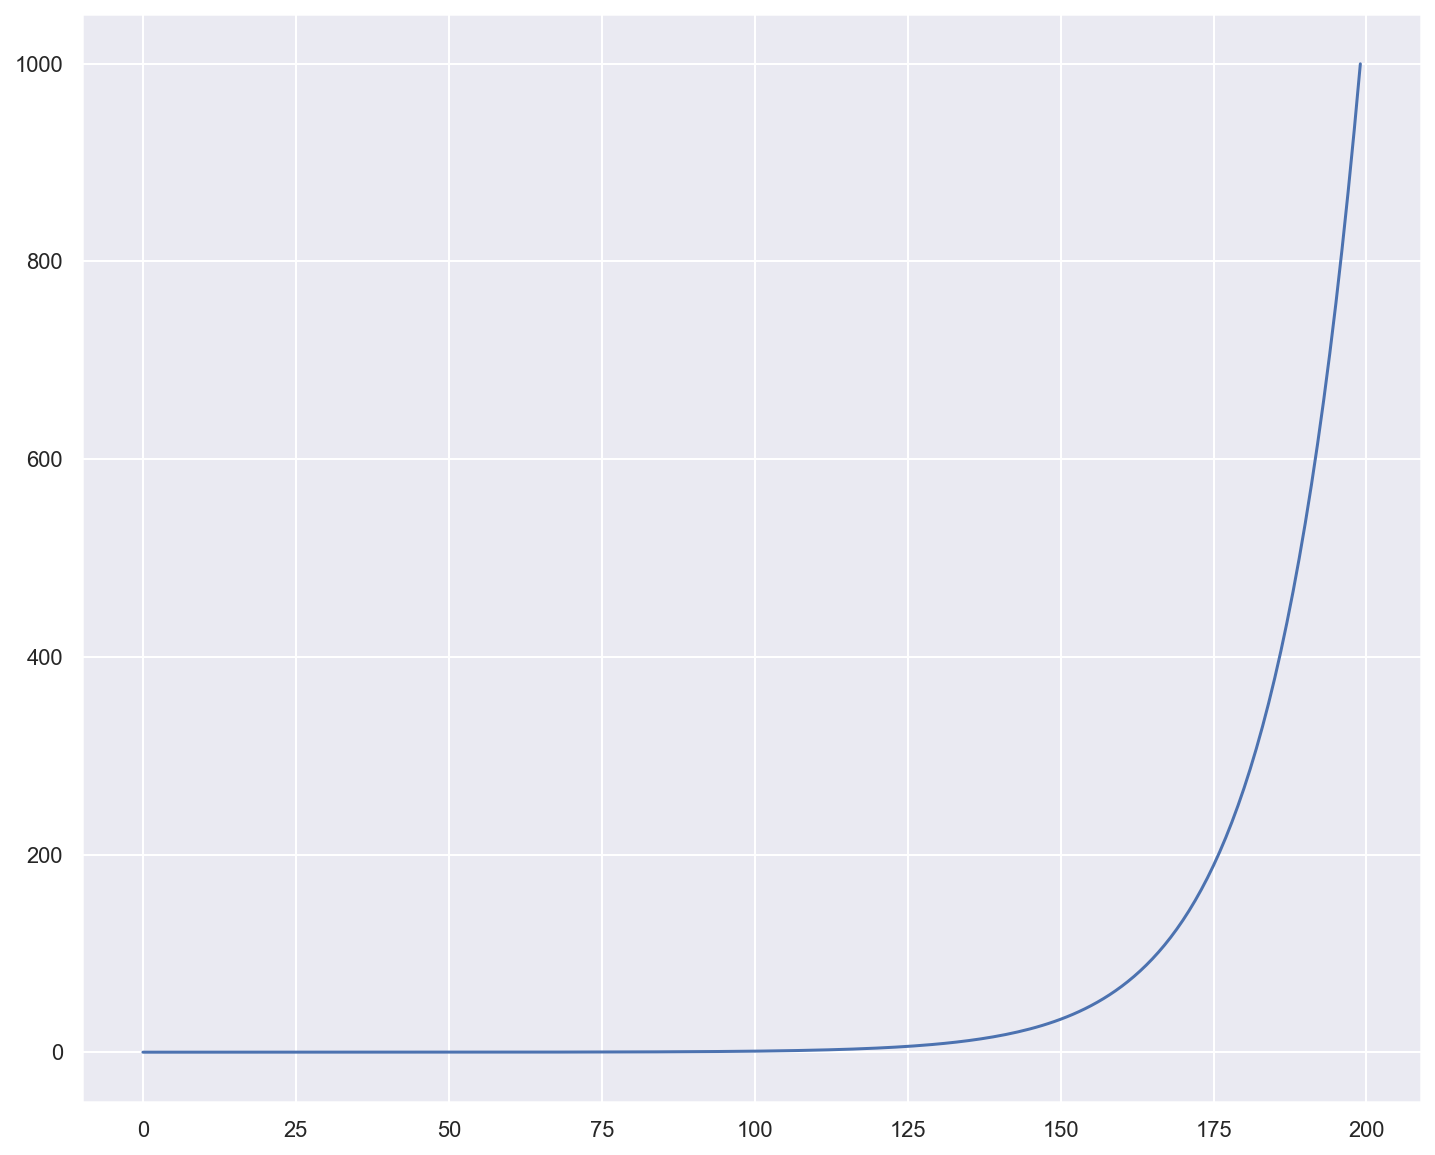

In [116]:
## 어떤 피처가 중요한 피처인지를 찾습니다.
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

# cross validation을 통해 최적의 알파값을 찾기 위해 알파값의 범위를 지정합니다.
alphavec = 10**np.linspace(-3,3,200)   # 알파값을 0.001 에서 1000 까지 만듭니다.
plt.plot(alphavec)

In [117]:
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
# 위에서 넣어준 알파값으로 최적의 알파값을 찾습니다.
print('LASSO best alpha: ', lasso_model.alpha_ )
# coefficients 값을 봅니다.
list(zip(X.columns, lasso_model.coef_)) 

LASSO best alpha:  0.001


[('const', 0.0),
 ('gender', -0.0010661891915392733),
 ('SeniorCitizen', 0.01646273843460924),
 ('Partner', 0.0),
 ('Dependents', -0.006895811117057331),
 ('PhoneService', -0.0),
 ('PaperlessBilling', 0.020965005641806846),
 ('MultipleLines_No', -0.01940146380136631),
 ('MultipleLines_No phone service', 0.0),
 ('MultipleLines_Yes', 0.005685987934927162),
 ('InternetService_DSL', -0.0),
 ('InternetService_Fiber optic', 0.07579327144723146),
 ('InternetService_No', -0.007475182669470293),
 ('OnlineSecurity_No', 0.024814868019476858),
 ('OnlineSecurity_Yes', -0.0),
 ('OnlineBackup_No', 0.010882516512912426),
 ('OnlineBackup_Yes', -0.0),
 ('DeviceProtection_No', 0.002347586851428435),
 ('DeviceProtection_Yes', -0.0),
 ('TechSupport_No', 0.024740875398156534),
 ('TechSupport_Yes', -0.0),
 ('StreamingTV_No', -0.0),
 ('StreamingTV_Yes', 0.020401788347634862),
 ('StreamingMovies_No', -0.0),
 ('StreamingMovies_Yes', 0.020195310960093634),
 ('Contract_Month-to-month', 0.046636306369139506),
 ('C

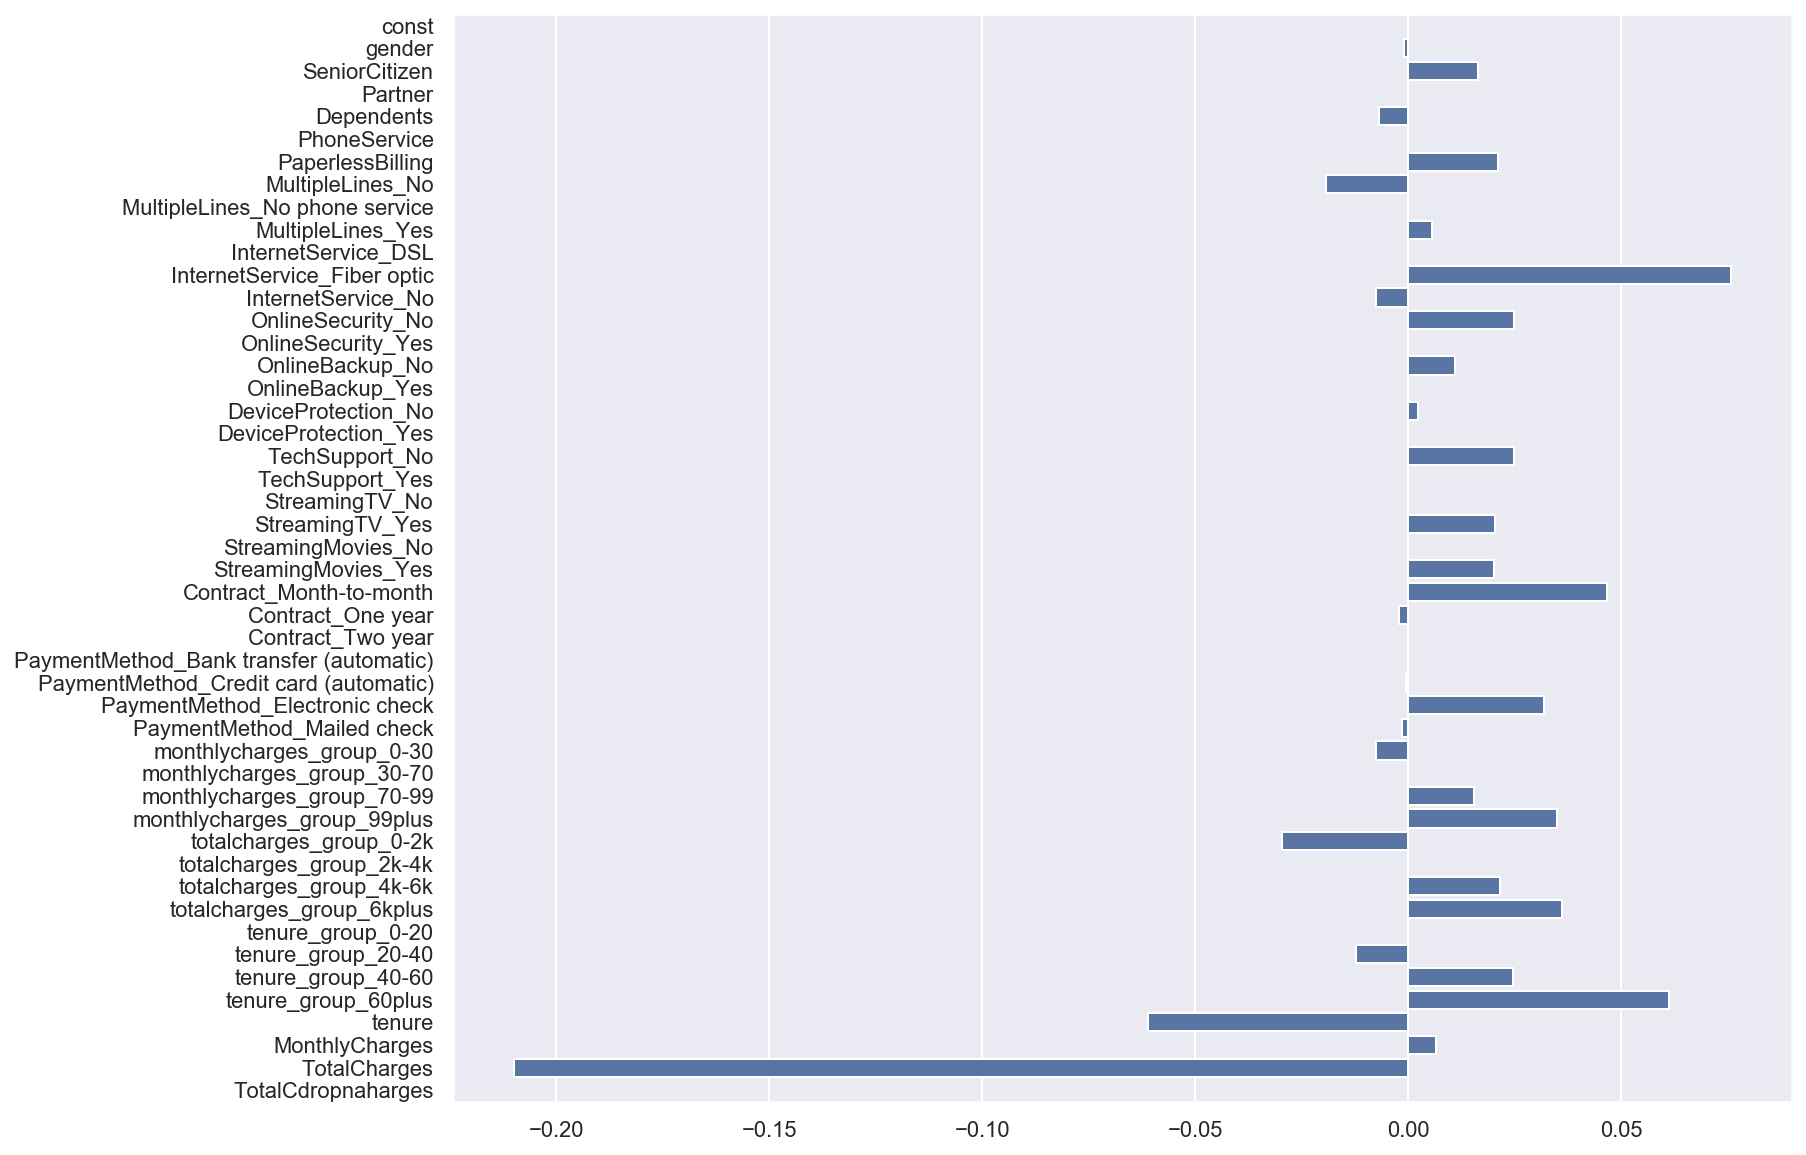

In [118]:
# 위 결정계수를 그래프로 시각화 합니다.

sns.barplot(x=lasso_model.coef_, y=X.columns, color='b')

Text(0.5, 1.0, 'Top Features derived by Random Forest')

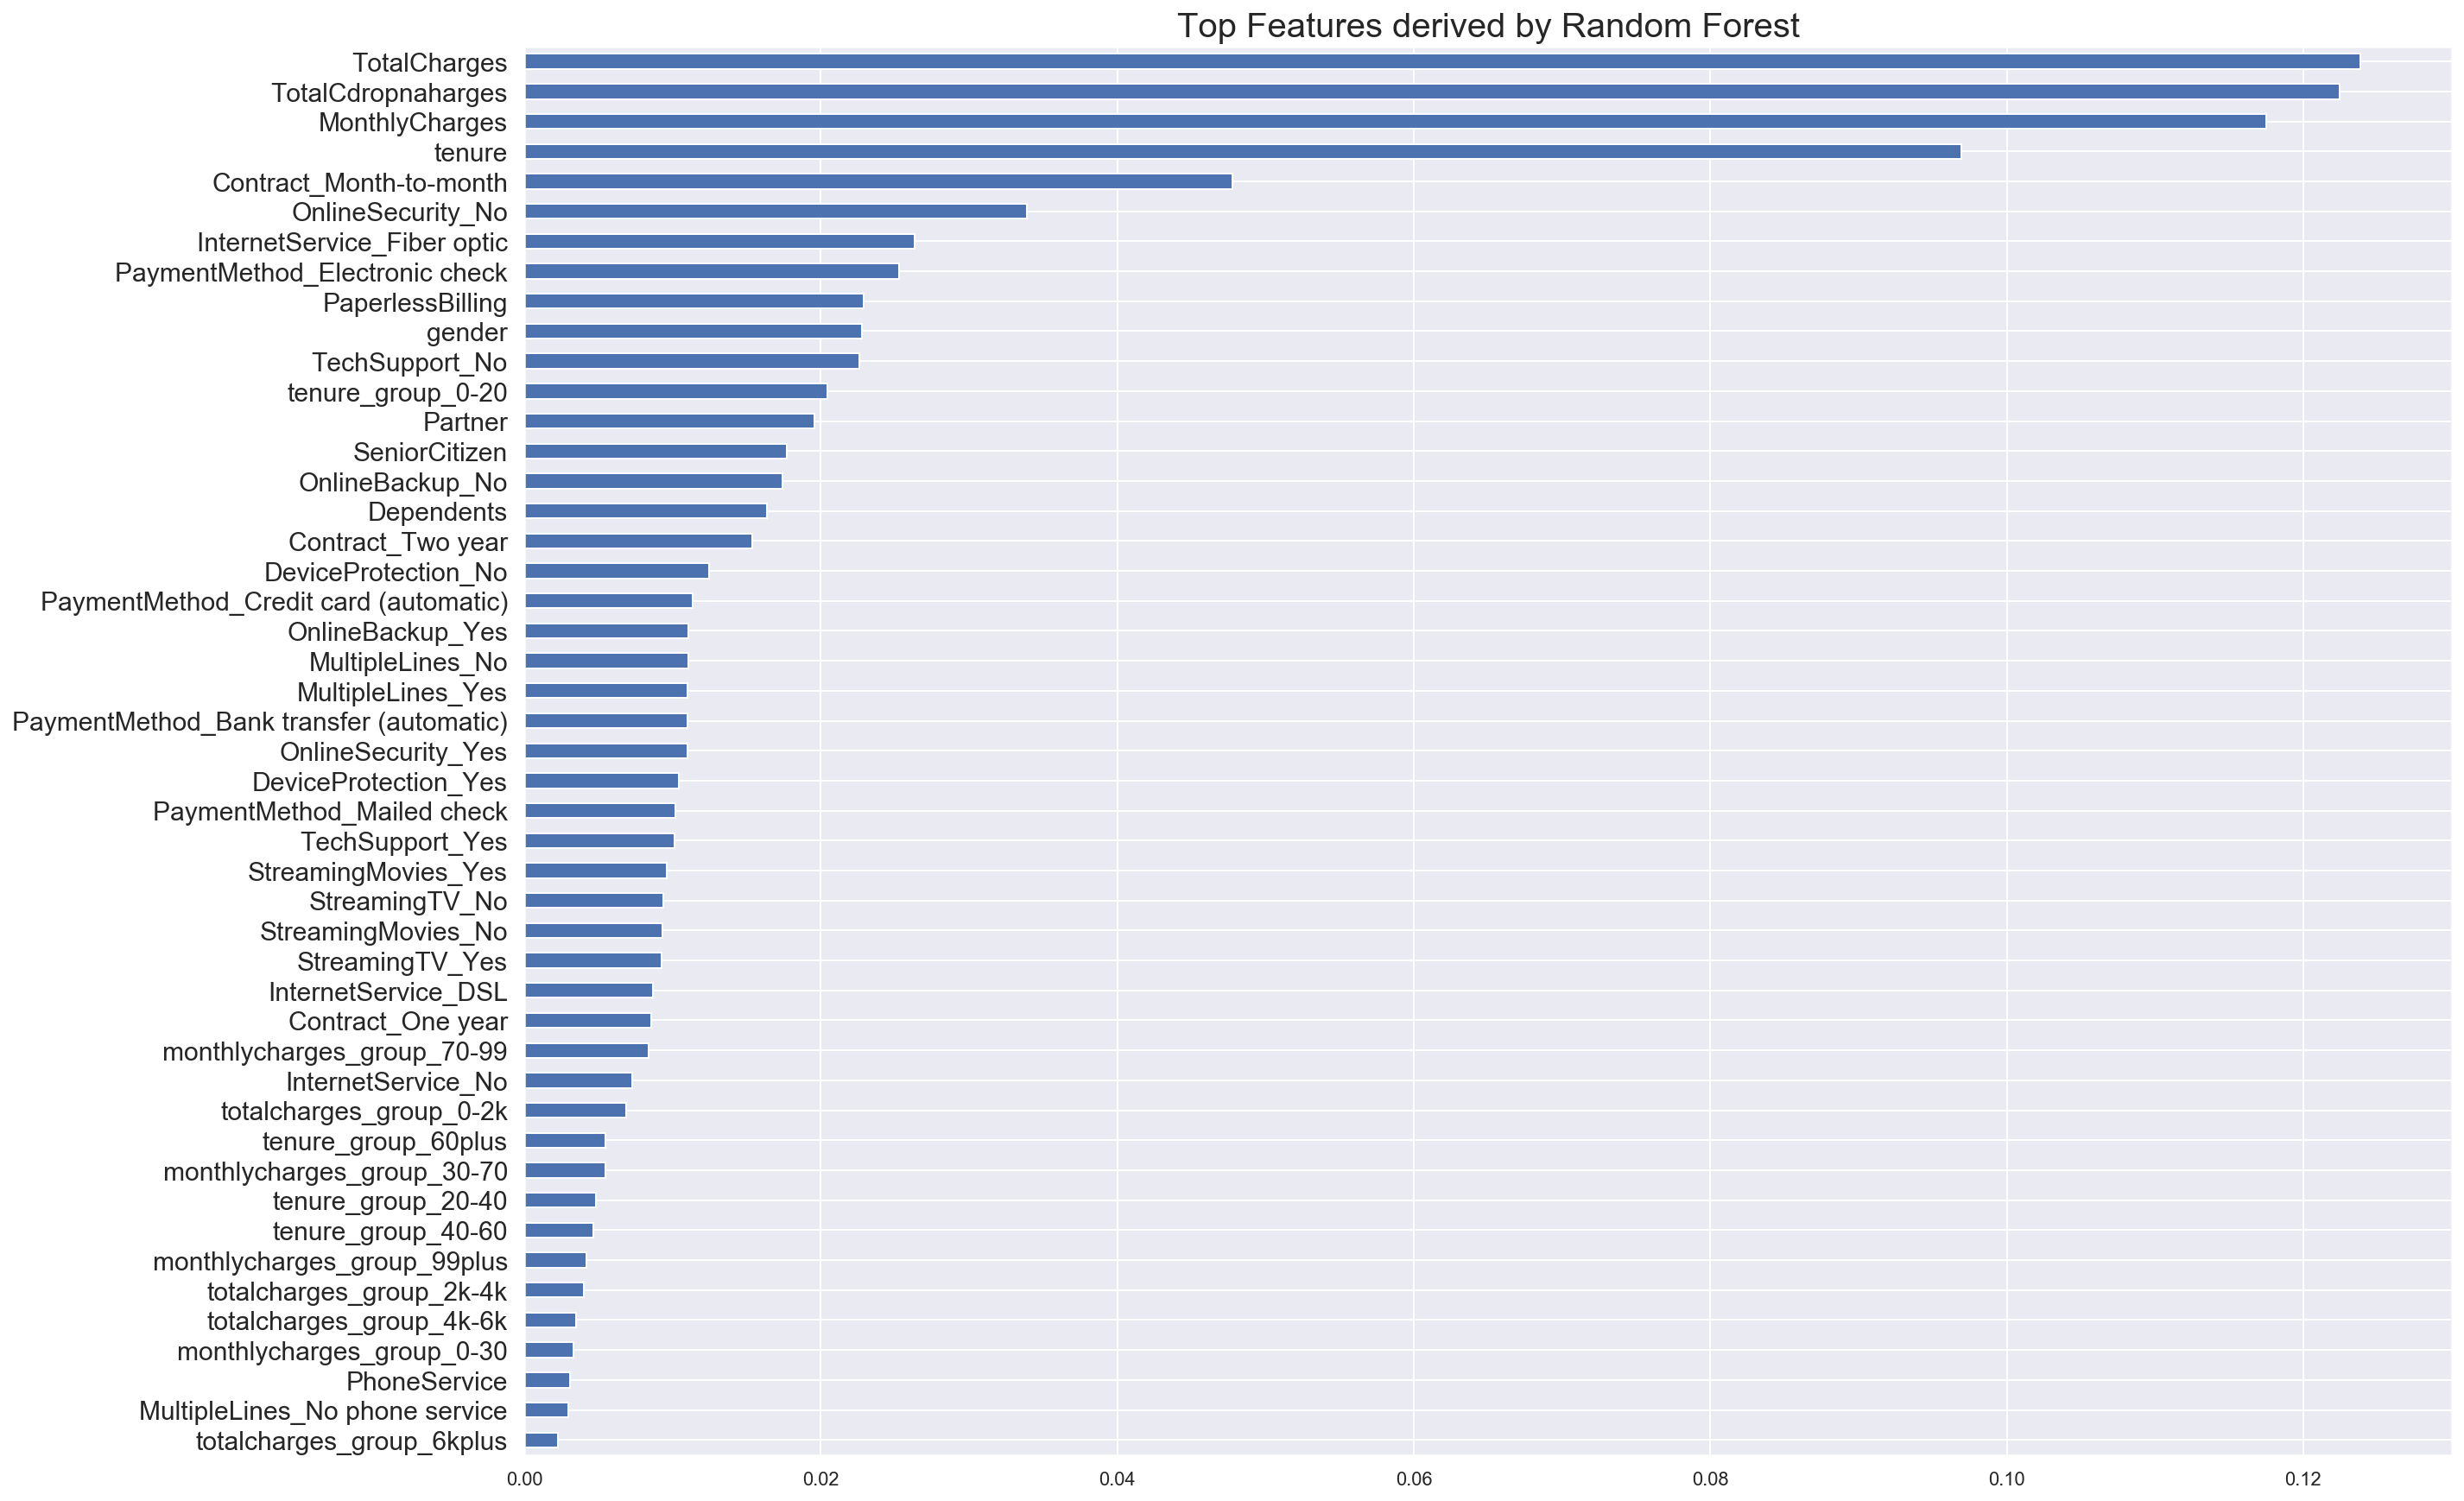

In [119]:
## To look for top features using Random Forest
# Create decision tree classifer object
rfc = RandomForestClassifier(random_state=0, n_estimators=100)

# Train model, note that NO scaling is required
model = rfc.fit(X, y)

# Plot the top features based on its importance
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(47)   # can adjust based on how many top features you want
   .plot(kind='barh', figsize=[20,15])
    .invert_yaxis()) # Ensures that the feature with the most importance is on top, in descending order

plt.yticks(size=15)
plt.title('Top Features derived by Random Forest', size=20)

## Model Selection

In [120]:
df1 = pd.read_csv('df1.csv')
X, y = df1.drop('Churn',axis=1), df1['Churn']

###  train test split

In [121]:
# split data to 80:20 ratio for train/test
# test_size=.2 로 데이터를 나눠주세요.
from sklearn.model_selection import train_test_split

# 여기에 코드를 작성합니다.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (5625, 47)
y_train (5625,)
X_test (1407, 47)
y_test (1407,)


### model report

In [128]:
def model_report(model_name, model):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
  

    # X_train, y_train 으로 모델을 학습하는 코드를 작성해 주세요
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            y_pred = (model.predict_proba(X_test)[:,1] >= th) # predict_proba 로 예측하게 합니다.
            f1scor = f1_score(y_test, y_pred) # y_test, y_pred 로 f1_score를 구해주세요.
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    print('Test set: {:.2f}%'.format(100*model.score(X_test, y_test)))   # should use cross validation

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    global model_f1, model_auc, model_ll, model_roc_auc
    model_f1 = f1_score(y_test, y_pred)

    y_pred = model.predict_proba(X_test)
    model_ll = log_loss(y_test, y_pred)
    print(model_name, 'Log-loss: {:.4f}'.format(model_ll))
    y_pred = model.predict(X_test)
    model_roc_auc = roc_auc_score(y_test, y_pred)
    print(model_name, 'roc_auc_score: {:.4f}'.format(model_roc_auc)) 
    y_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    model_auc = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(model_auc))

    # plot the ROC curve
    plt.figure(figsize = [6,6])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    # plt.savefig('roc_auc_score')
    plt.show()
  
    return

# initialise lists to collect the results to plot later
model_list = []
f1_list = []
auc_list = []
ll_list = []
roc_auc_list = []
time_list = []

### GaussianNB


"""""" GaussianNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5566,  0.100->0.5941,  0.200->0.6010,  0.300->0.6037,  0.400->0.6058,  0.500->0.6082,  0.600->0.6105,  0.700->0.6111,  0.800->0.6152,  0.900->0.6082,  1.000->0.5698,  
Looping decimal place 2
0.700->0.6111,  0.710->0.6103,  0.720->0.6103,  0.730->0.6109,  0.740->0.6122,  0.750->0.6136,  0.760->0.6142,  0.770->0.6142,  0.780->0.6141,  0.790->0.6139,  0.800->0.6152,  0.810->0.6135,  0.820->0.6142,  0.830->0.6142,  0.840->0.6149,  0.850->0.6110,  0.860->0.6110,  0.870->0.6110,  0.880->0.6086,  0.890->0.6091,  0.900->0.6082,  
Looping decimal place 3
0.790->0.6139,  0.791->0.6145,  0.792->0.6145,  0.793->0.6145,  0.794->0.6145,  0.795->0.6145,  0.796->0.6152,  0.797->0.6152,  0.798->0.6152,  0.799->0.6152,  0.800->0.6152,  0.801->0.6152,  0.802->0.6152,  0.803->0.6152,  0.804->0.6152,  0.805->0.6159,  0.806->0.6144,  0.807->0.6144,  0.808->0.

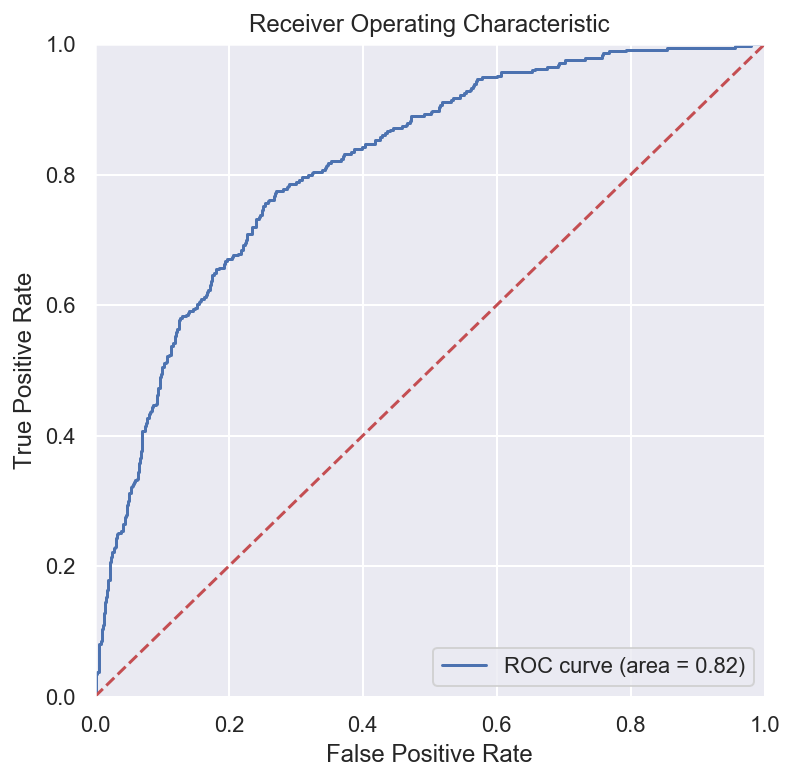

In [129]:
print('\n"""""" GaussianNB """"""')
time1 = time.time()
gnb = GaussianNB()
model_report('GaussianNB', gnb) # 위에서 작성한 모델 리포트 함수를 부릅니다.

model_list.append('GaussianNB')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### BernoulliNB


"""""" BernoulliNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5271,  0.100->0.5941,  0.200->0.6039,  0.300->0.5992,  0.400->0.6011,  0.500->0.6047,  0.600->0.6034,  0.700->0.6090,  0.800->0.6069,  0.900->0.6025,  1.000->0.3416,  
Looping decimal place 2
0.600->0.6034,  0.610->0.6034,  0.620->0.6025,  0.630->0.6025,  0.640->0.6039,  0.650->0.6052,  0.660->0.6080,  0.670->0.6071,  0.680->0.6071,  0.690->0.6069,  0.700->0.6090,  0.710->0.6104,  0.720->0.6079,  0.730->0.6068,  0.740->0.6066,  0.750->0.6073,  0.760->0.6085,  0.770->0.6068,  0.780->0.6066,  0.790->0.6064,  0.800->0.6069,  
Looping decimal place 3
0.700->0.6090,  0.701->0.6097,  0.702->0.6097,  0.703->0.6097,  0.704->0.6097,  0.705->0.6097,  0.706->0.6097,  0.707->0.6097,  0.708->0.6097,  0.709->0.6104,  0.710->0.6104,  0.711->0.6104,  0.712->0.6104,  0.713->0.6104,  0.714->0.6104,  0.715->0.6088,  0.716->0.6088,  0.717->0.6079,  0.718->0

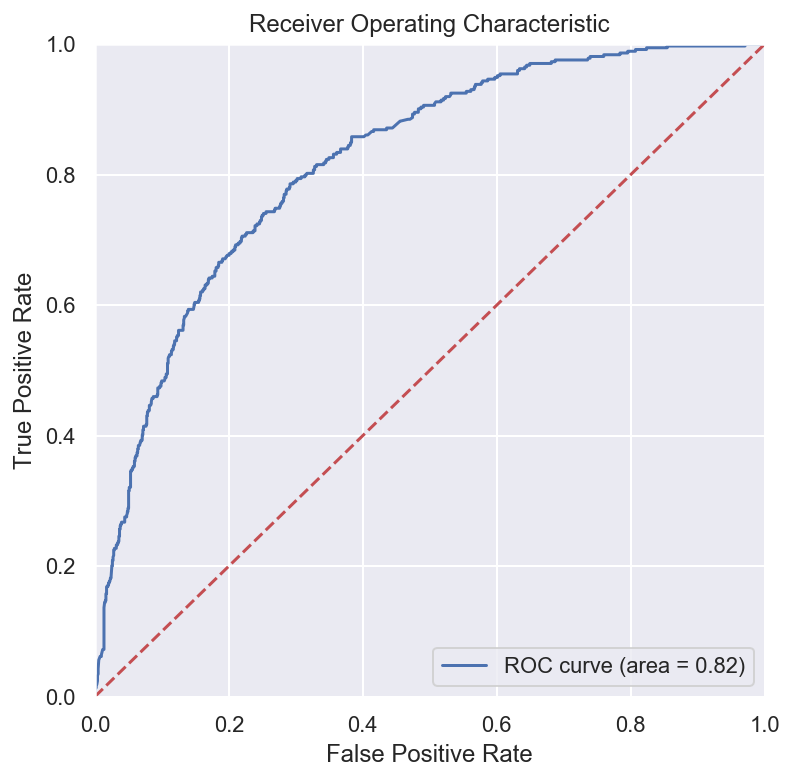

In [130]:
print('\n"""""" BernoulliNB """"""')
time1 = time.time()
bnb = BernoulliNB()
model_report('BernoulliNB', bnb) # 위에서 작성한 모델 리포트 함수를 부릅니다.

model_list.append('BernoulliNB')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### LogisticRegression


"""""" LogisticRegression """"""

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.3998, 0.4162, 0.4355, 0.4440, 0.4549, 0.4623, 0.4704, 0.4804, 0.4894, 0.4937, 0.5004, 0.5050, 0.5117, 0.5165, 0.5214, 0.5290, 0.5329, 0.5344, 0.5350, 0.5415, 0.5455, 0.5509, 0.5528, 0.5547, 0.5571, 0.5592, 0.5635, 0.5646, 0.5677, 0.5680, 0.5700, 0.5718, 0.5720, 0.5758, 0.5762, 0.5770, 0.5801, 0.5814, 0.5841, 0.5862, 0.5863, 0.5890, 0.5881, 0.5874, 0.5874, 0.5920, 0.5927, 0.5953, 0.5962, 0.5980, 0.5992, 0.5987, 0.5985, 0.5986, 0.5994, 0.5991, 0.5991, 0.5991, 0.5994, 0.6000, 0.5997, 0.6010, 0.6015, 0.6020, 0.6010, 0.6009, 0.6003, 0.6021, 0.6018, 0.6021, 0.6021, 0.6016, 0.6016, 0.6023, 0.6031, 0.6031, 0.6028, 0.6039, 0.6037, 0.6037, 0.6033, 0.6045, 0.6040, 0.6053, 0.6057, 0.6073, 0.6078, 0.6083, 0.6085, 0.6086, 0.6083, 0.6081, 0.6061, 0.6064, 0.6062, 0.6067, 0.6054, 0.6060, 0.6067, 0.6063, 0.6053, 0.6068, 0.6043, 0.6051, 

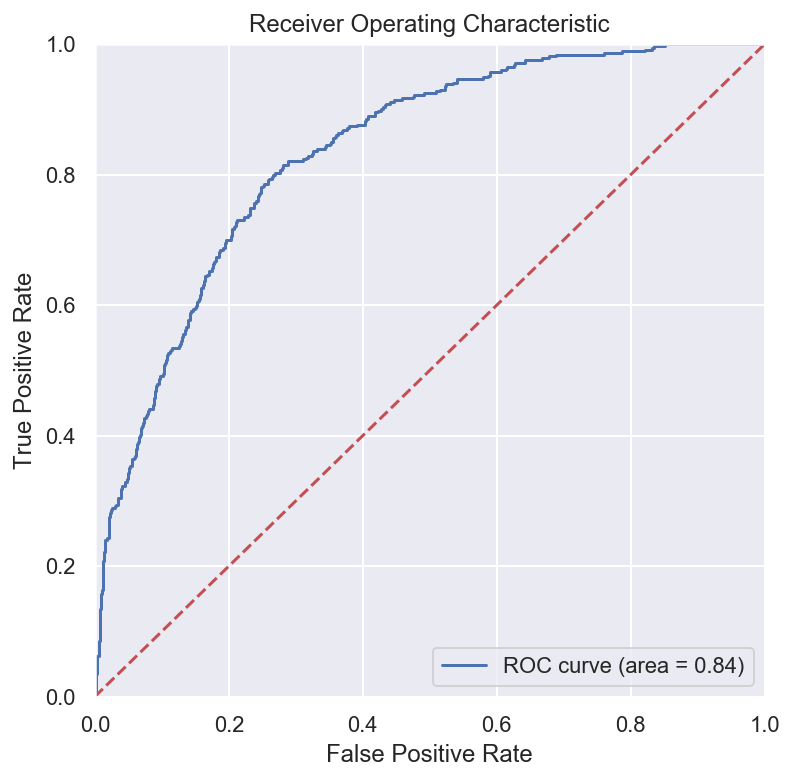

In [131]:
print('\n"""""" LogisticRegression """"""')
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,200)

for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

time1 = time.time()
logit = LogisticRegression(C = optimal_c)
model_report('LogisticRegression', logit)

model_list.append('LogisticRegression')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### KNN


"""""" KNN """""" (quite slow)

Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.4941, 0.4085, 0.5587, 0.5067, 0.5669, 0.5354, 0.5876, 0.5488, 0.5836, 0.5636, 0.5884, 0.5696, 0.5840, 0.5666, 0.5898, 0.5753, 0.5910, 0.5819, 0.5943, 0.5915, optimal cv F1 score = 0.5943
optimal value of K = 19

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4857,  0.100->0.5286,  0.200->0.5736,  0.300->0.5803,  0.400->0.5925,  0.500->0.5590,  0.600->0.4820,  0.700->0.3501,  0.800->0.1401,  0.900->0.0159,  1.000->0.0000,  
Looping decimal place 2
0.300->0.5803,  0.310->0.5803,  0.320->0.5855,  0.330->0.5855,  0.340->0.5855,  0.350->0.5855,  0.360->0.5855,  0.370->0.5925,  0.380->0.5925,  0.390->0.5925,  0.400->0.5925,  0.410->0.5925,  0.420->0.5925,  0.430->0.5815,  0.440->0.5815,  0.450->0.5815,  0.460->0.5815,  0.470->0.5815,  0.480->0.5590,  0.490->0.5590,  0.500->

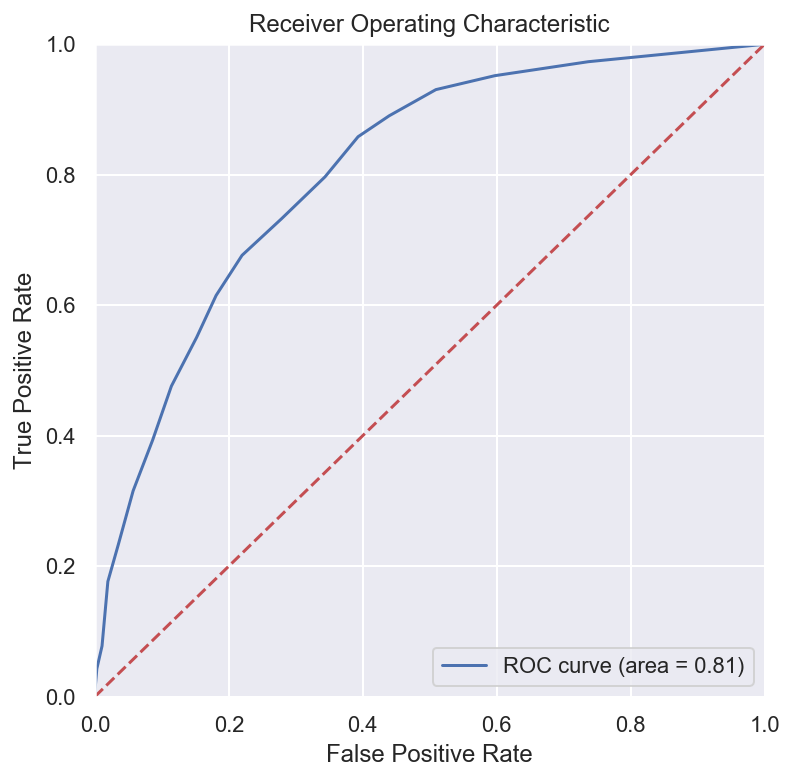


Compare with KNN classification_report (same as default threshold 0.50)
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1033
           1       0.57      0.55      0.56       374

    accuracy                           0.77      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.77      0.77      0.77      1407



In [132]:
print('\n"""""" KNN """""" (quite slow)')
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

time1 = time.time()
knn = KNeighborsClassifier(n_neighbors = optimal_k)
model_report('KNN', knn)

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

model_list.append('KNN')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

In [ ]:
# Optimal threshold 0.264
# Precision: 0.5104,   Recall: 0.8205,   F1 Score: 0.6293
# KNN confusion matrix: 
#  [[710 307]
#  [ 70 320]]
# KNN Log-loss: 0.6104
# KNN roc_auc_score: 0.7172
# KNN AUC: 0.8309

### DecisionTreeClassifier


"""""" DecisionTreeClassifier """"""

Search for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data
0.5878, 0.4950, 0.5820, 0.6137, 0.6008, 0.5852, 0.5707, 0.5668, 0.5516, optimal F1 score = 0.6137
optimal max_depth = 5

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4200,  0.100->0.5477,  0.200->0.6020,  0.300->0.6020,  0.400->0.5772,  0.500->0.5772,  0.600->0.3570,  0.700->0.3570,  0.800->0.2048,  0.900->0.0000,  1.000->0.0000,  
Looping decimal place 2
0.200->0.6020,  0.210->0.6065,  0.220->0.6083,  0.230->0.6083,  0.240->0.6083,  0.250->0.6020,  0.260->0.6020,  0.270->0.6020,  0.280->0.6020,  0.290->0.6020,  0.300->0.6020,  0.310->0.6020,  0.320->0.6067,  0.330->0.6067,  0.340->0.6067,  0.350->0.6009,  0.360->0.5845,  0.370->0.5845,  0.380->0.5845,  0.390->0.5775,  0.400->0.5772,  
Looping decimal place 3
0.210->0.6065,  0.211->0.6065,  0.212->0.6065,  0.213->0.6

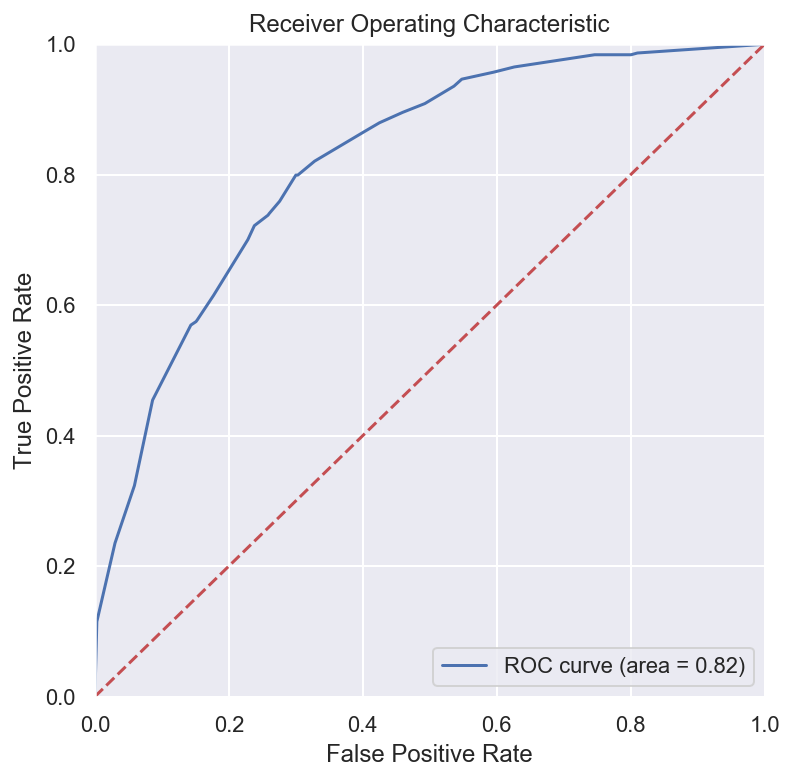

In [133]:
print('\n"""""" DecisionTreeClassifier """"""')

print('\nSearch for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
d_scores = []
for d in range(2, 11):
    decisiontree = DecisionTreeClassifier(max_depth=d)
    cvs = cross_val_score(decisiontree, X_train, y_train, cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

time1 = time.time()
decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model_report('DecisionTreeClassifier', decisiontree)

model_list.append('DecisionTreeClassifier')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

In [ ]:
# Optimal threshold 0.2866
# Precision: 0.5687,   Recall: 0.6154,   F1 Score: 0.5911
# DecisionTreeClassifier confusion matrix: 
#  [[835 182]
#  [150 240]]

### RandomForestClassifier


"""""" RandomForestClassifier """""" (quite slow)

Search for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data
100->0.5677, 150->0.5675, 200->0.5663, 250->0.5675, 300->0.5692, 350->0.5702, 400->0.5721, 450->0.5689, 500->0.5641, optimal F1 score = 0.5721
optimal n_estimators = 400

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4433,  0.100->0.5430,  0.200->0.5842,  0.300->0.5993,  0.400->0.5879,  0.500->0.5284,  0.600->0.4939,  0.700->0.3570,  0.800->0.2616,  0.900->0.1646,  1.000->0.0106,  
Looping decimal place 2
0.200->0.5842,  0.210->0.5901,  0.220->0.5948,  0.230->0.5988,  0.240->0.5958,  0.250->0.5948,  0.260->0.5957,  0.270->0.5890,  0.280->0.5957,  0.290->0.5946,  0.300->0.5993,  0.310->0.5957,  0.320->0.5896,  0.330->0.5928,  0.340->0.5935,  0.350->0.5931,  0.360->0.5915,  0.370->0.5911,  0.380->0.5965,  0.390->0.5921,  0.400->0.5879,  
Looping decim

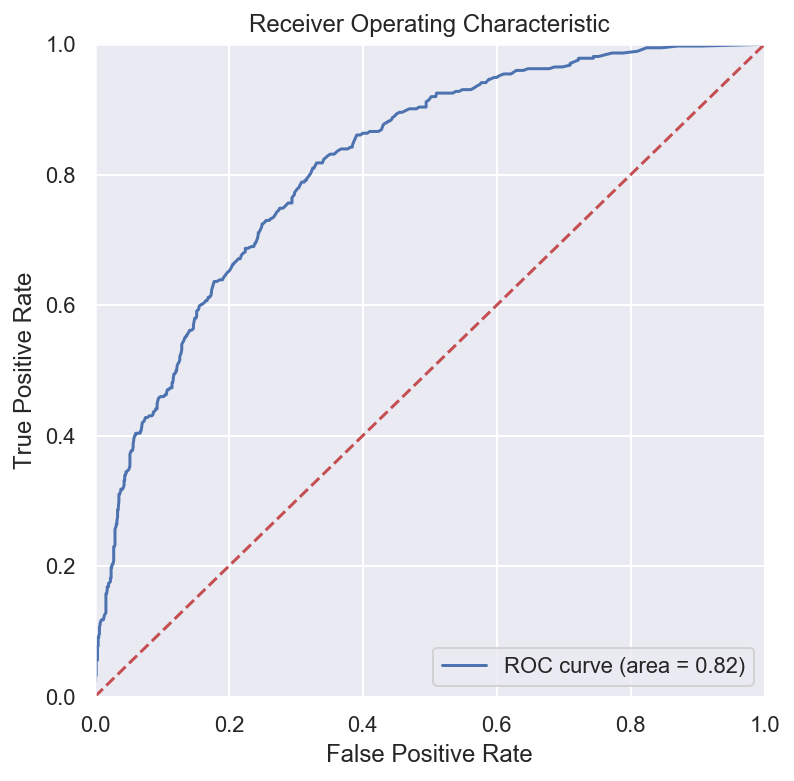

In [134]:
print('\n"""""" RandomForestClassifier """""" (quite slow)')

print('\nSearch for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

time1 = time.time()
randomforest = RandomForestClassifier(n_estimators=optimal_n)
model_report('RandomForestClassifier', randomforest)

model_list.append('RandomForestClassifier')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

In [ ]:
# Optimal threshold 0.340
# Precision: 0.5830,   Recall: 0.7026,   F1 Score: 0.6372
# RandomForestClassifier confusion matrix: 
#  [[821 196]
#  [116 274]]
# RandomForestClassifier Log-loss: 0.4724
# RandomForestClassifier roc_auc_score: 0.6946
# RandomForestClassifier AUC: 0.8272

### LinearSVC


"""""" LinearSVC """"""
LinearSVC accuracy score is
Training: 80.59%
Test set: 79.39%
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.65      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

LinearSVC confusion matrix: 
 [[939  94]
 [196 178]]
LinearSVC Log-loss: 7.1189
LinearSVC roc_auc_score: 0.6925
LinearSVC AUC: 0.6925


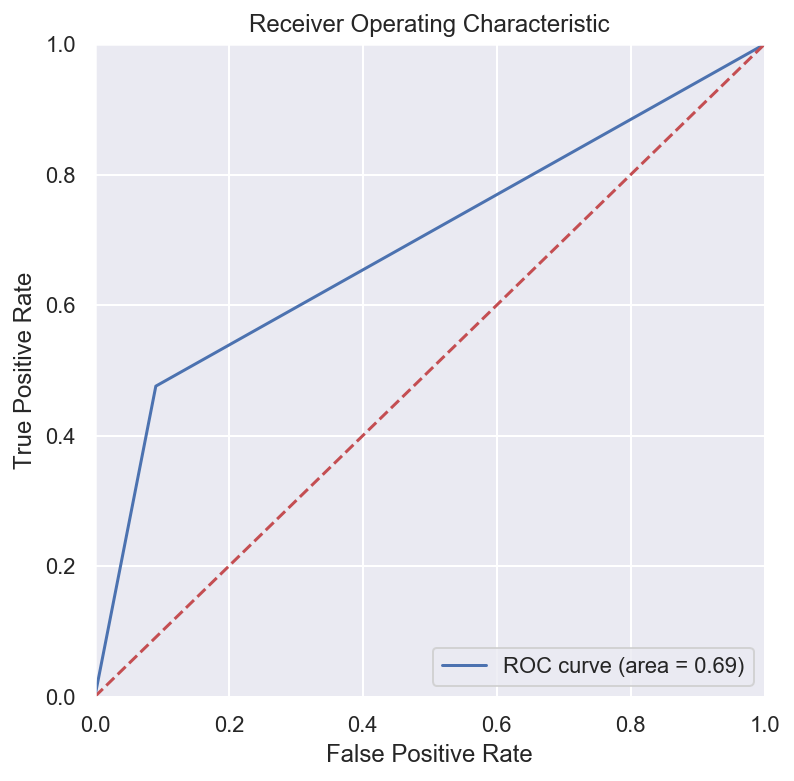

In [135]:
print('\n"""""" LinearSVC """"""')
time1 = time.time()
linearsvc = LinearSVC()
# model_report('LinearSVC', linearsvc)   # model has no attribute 'predict_proba'
linearsvc.fit(X_train, y_train)
print('LinearSVC accuracy score is')
print('Training: {:.2f}%'.format(100*linearsvc.score(X_train, y_train)))  # score uses accuracy
print('Test set: {:.2f}%'.format(100*linearsvc.score(X_test, y_test)))   # should use cross validation

y_pred = linearsvc.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print('LinearSVC confusion matrix: \n', confusion_matrix(y_test, y_pred))

model_f1 = f1_score(y_test, y_pred)

model_ll = log_loss(y_test, y_pred)
print('LinearSVC Log-loss: {:.4f}'.format(model_ll))
model_roc_auc = roc_auc_score(y_test, y_pred)
print('LinearSVC roc_auc_score: {:.4f}'.format(model_roc_auc)) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
model_auc = auc(fpr, tpr)
print('LinearSVC AUC: {:.4f}'.format(model_auc))

# plot the ROC curve
plt.figure(figsize = [6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# plt.savefig('roc_auc_score')
plt.show()

model_list.append('LinearSVC')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

In [ ]:
# LinearSVC confusion matrix: 
#  [[933  84]
#  [201 189]]
# LinearSVC Log-loss: 6.9962
# LinearSVC roc_auc_score: 0.7010
# LinearSVC AUC: 0.7010

### SVC


"""""" SVC """""" (extremely slow)

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.4200,  0.100->0.4287,  0.200->0.6097,  0.300->0.5844,  0.400->0.5496,  0.500->0.5227,  0.600->0.4767,  0.700->0.4229,  0.800->0.1963,  0.900->0.0053,  1.000->0.0000,  
Looping decimal place 2
0.100->0.4287,  0.110->0.4323,  0.120->0.4447,  0.130->0.4742,  0.140->0.5321,  0.150->0.5849,  0.160->0.5931,  0.170->0.5904,  0.180->0.5976,  0.190->0.6063,  0.200->0.6097,  0.210->0.6090,  0.220->0.6022,  0.230->0.5980,  0.240->0.6003,  0.250->0.5995,  0.260->0.5982,  0.270->0.5893,  0.280->0.5885,  0.290->0.5911,  0.300->0.5844,  
Looping decimal place 3
0.190->0.6063,  0.191->0.6061,  0.192->0.6061,  0.193->0.6059,  0.194->0.6066,  0.195->0.6073,  0.196->0.6078,  0.197->0.6078,  0.198->0.6092,  0.199->0.6099,  0.200->0.6097,  0.201->0.6111,  0.202->0.6086,  0.203->0.6093,  0.204->0.6082,  0.205->0.6096,  0.206->0.6061,  0.207->0.6076, 

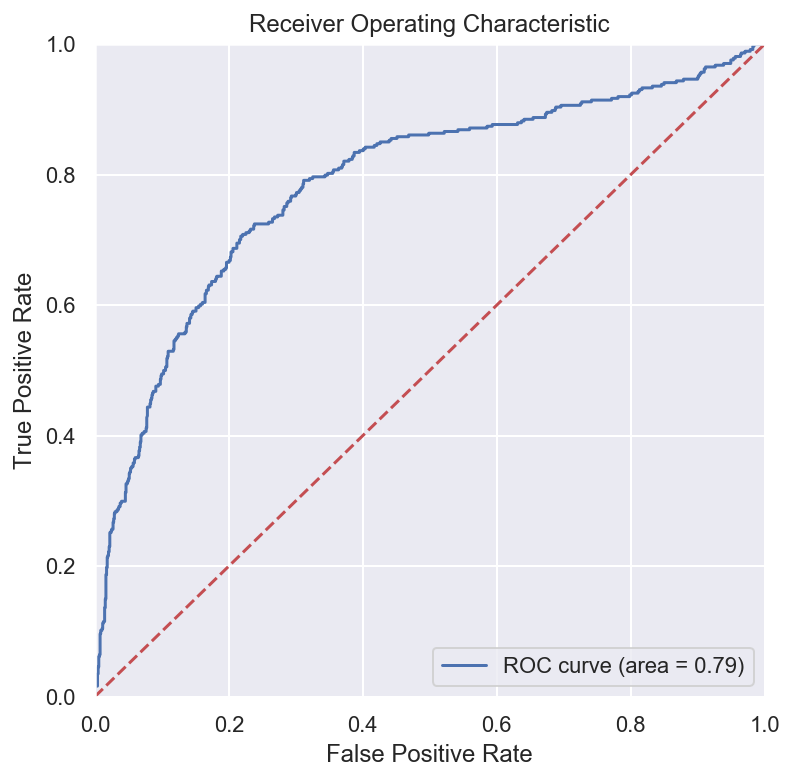

In [136]:
print('\n"""""" SVC """""" (extremely slow)')
time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model_report('SVC', svc)

model_list.append('SVC')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
# time_list.append(time.time() - time1)   # use this line for actual time spent, or
time_list.append(0)                       # use this line to be able to see time spent for other models

In [ ]:
# Optimal threshold 0.184
# Precision: 0.5884,   Recall: 0.7256,   F1 Score: 0.6498
# SVC confusion matrix: 
#  [[819 198]
#  [107 283]]
# SVC Log-loss: 0.4682
# SVC roc_auc_score: 0.6921
# SVC AUC: 0.7970

### Scoring

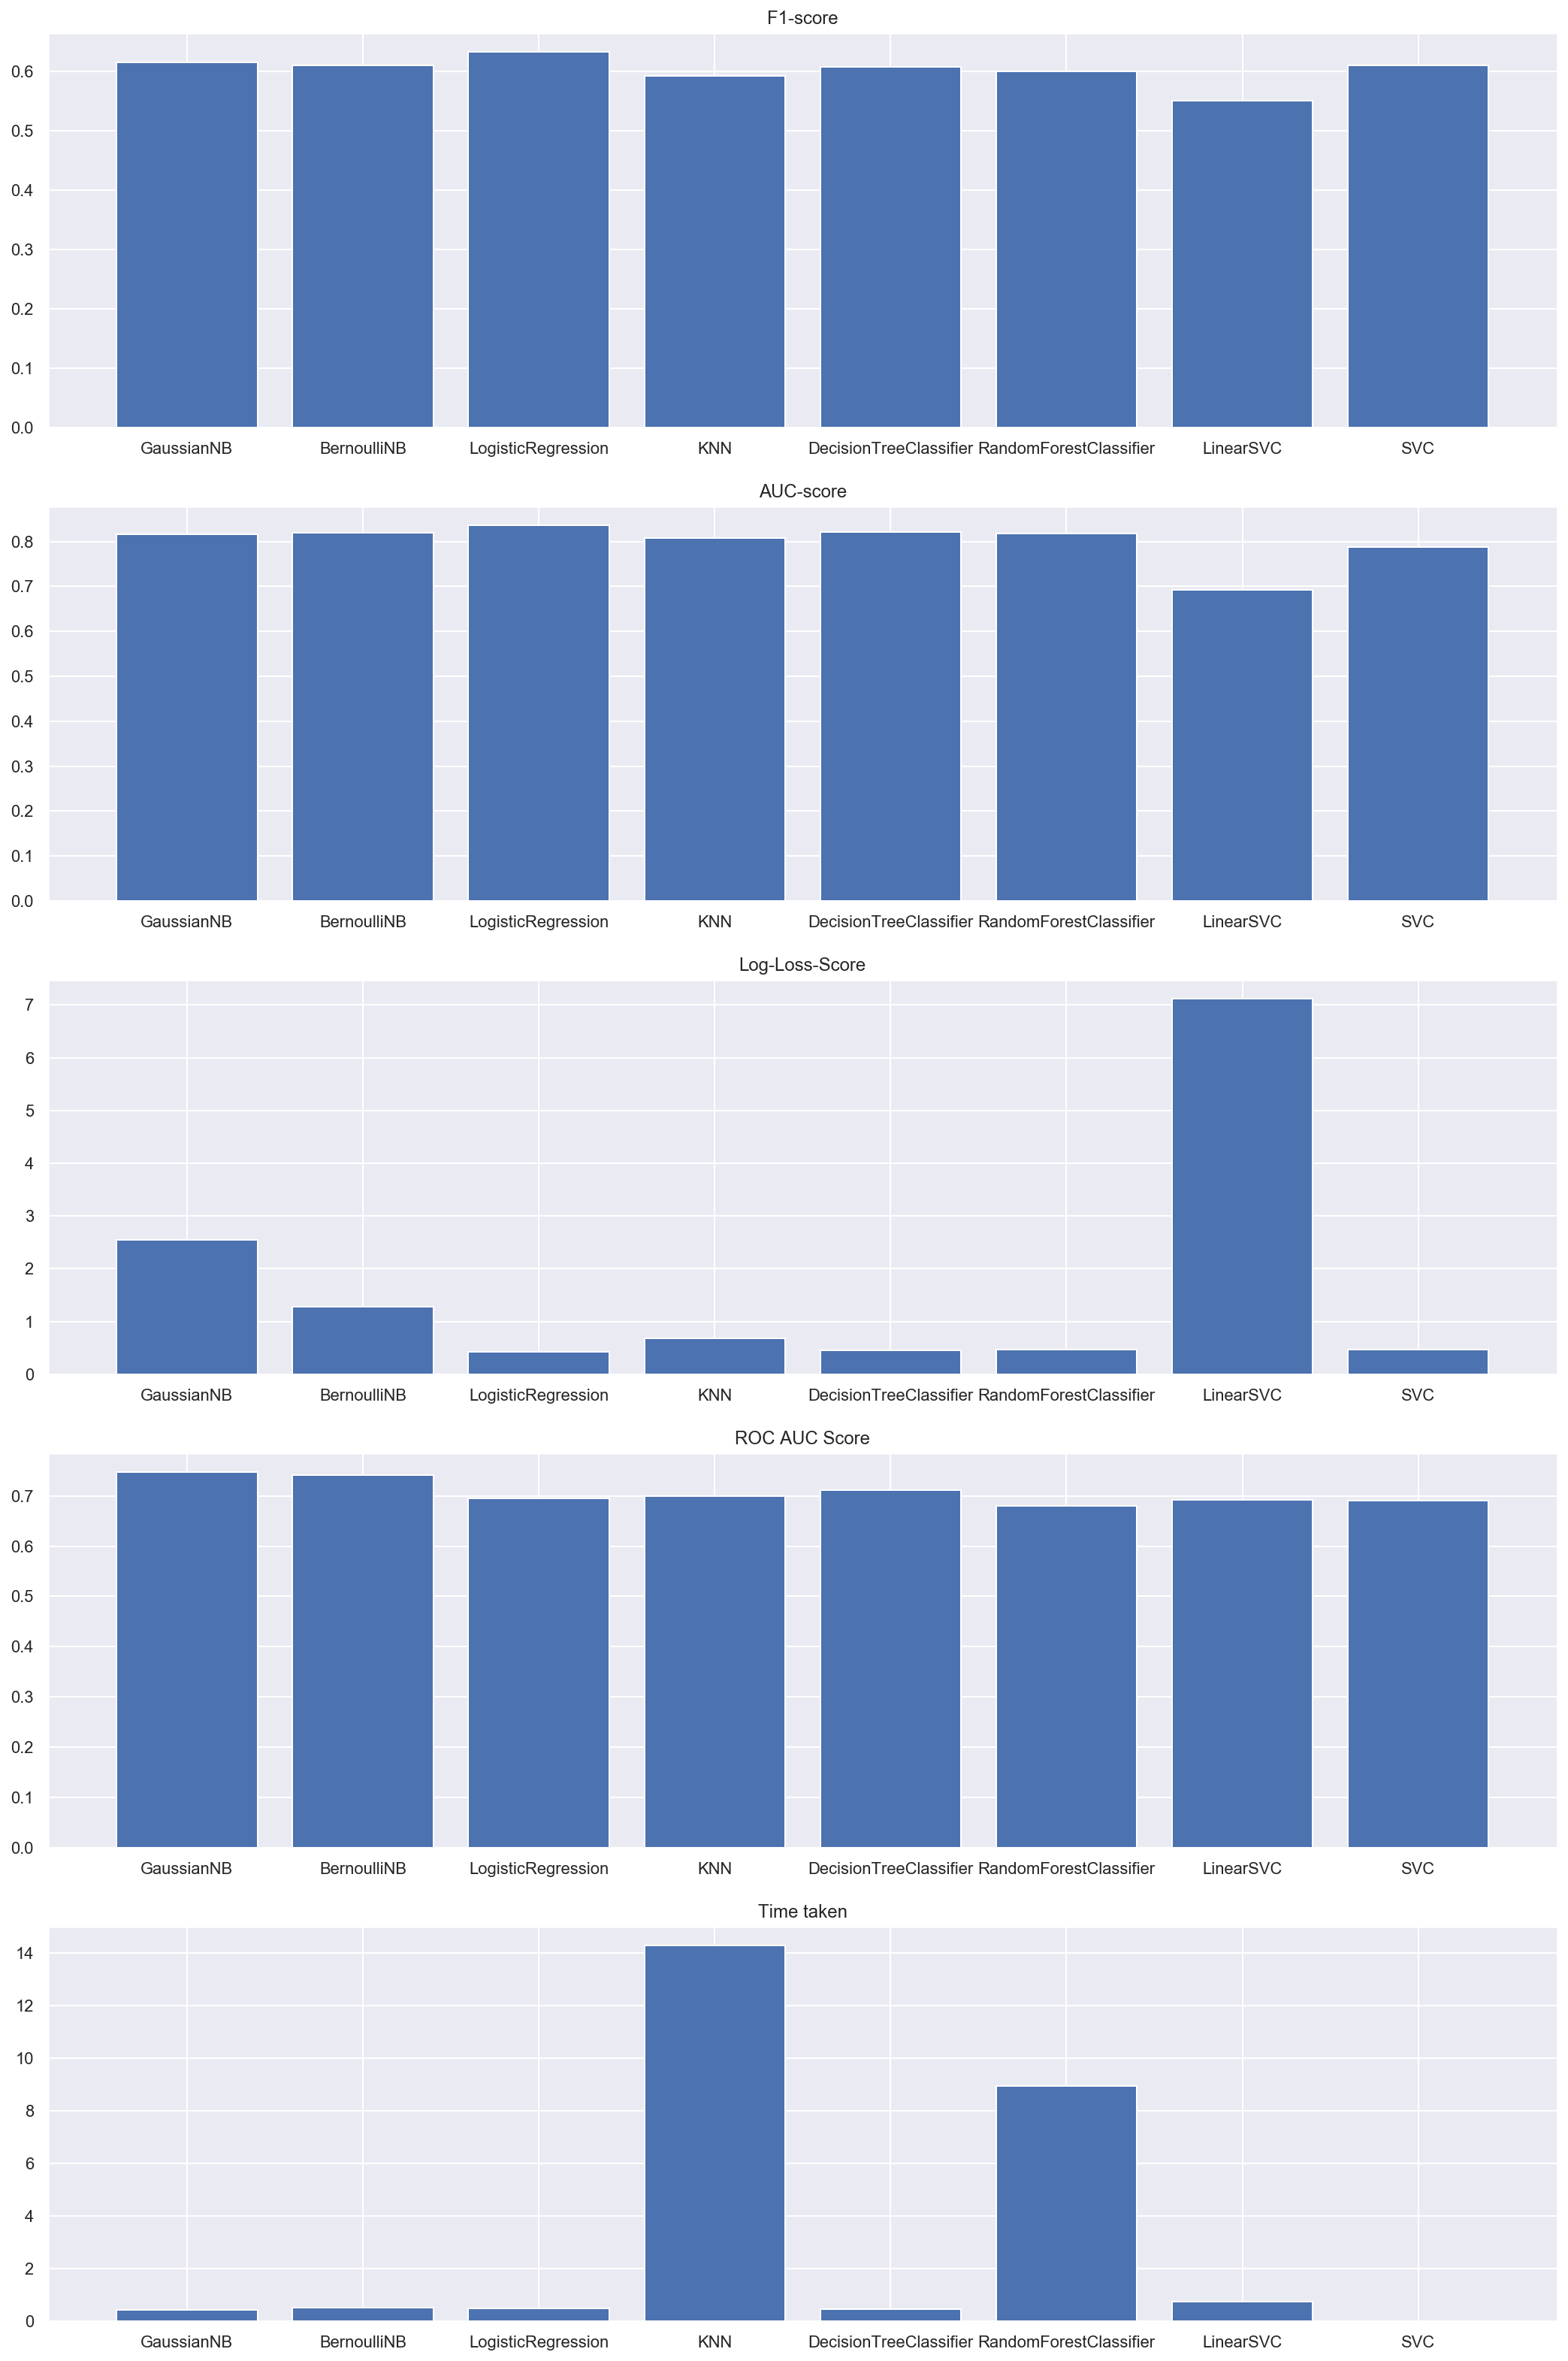

In [137]:
## plot the classification report scores
fig, ax = plt.subplots(5, 1, figsize=(18, 28))
# fig.set_figwidth(10)
# fig.set_figheight(6)
# fig.suptitle('Main Title',fontsize = 16)
ax[0].bar(model_list, f1_list)
ax[0].set_title('F1-score')
ax[1].bar(model_list, auc_list)
ax[1].set_title('AUC-score');
ax[2].bar(model_list, ll_list)
ax[2].set_title('Log-Loss-Score')
ax[3].bar(model_list, roc_auc_list)
ax[3].set_title('ROC AUC Score')
ax[4].bar(model_list, time_list)
ax[4].set_title('Time taken')
# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)

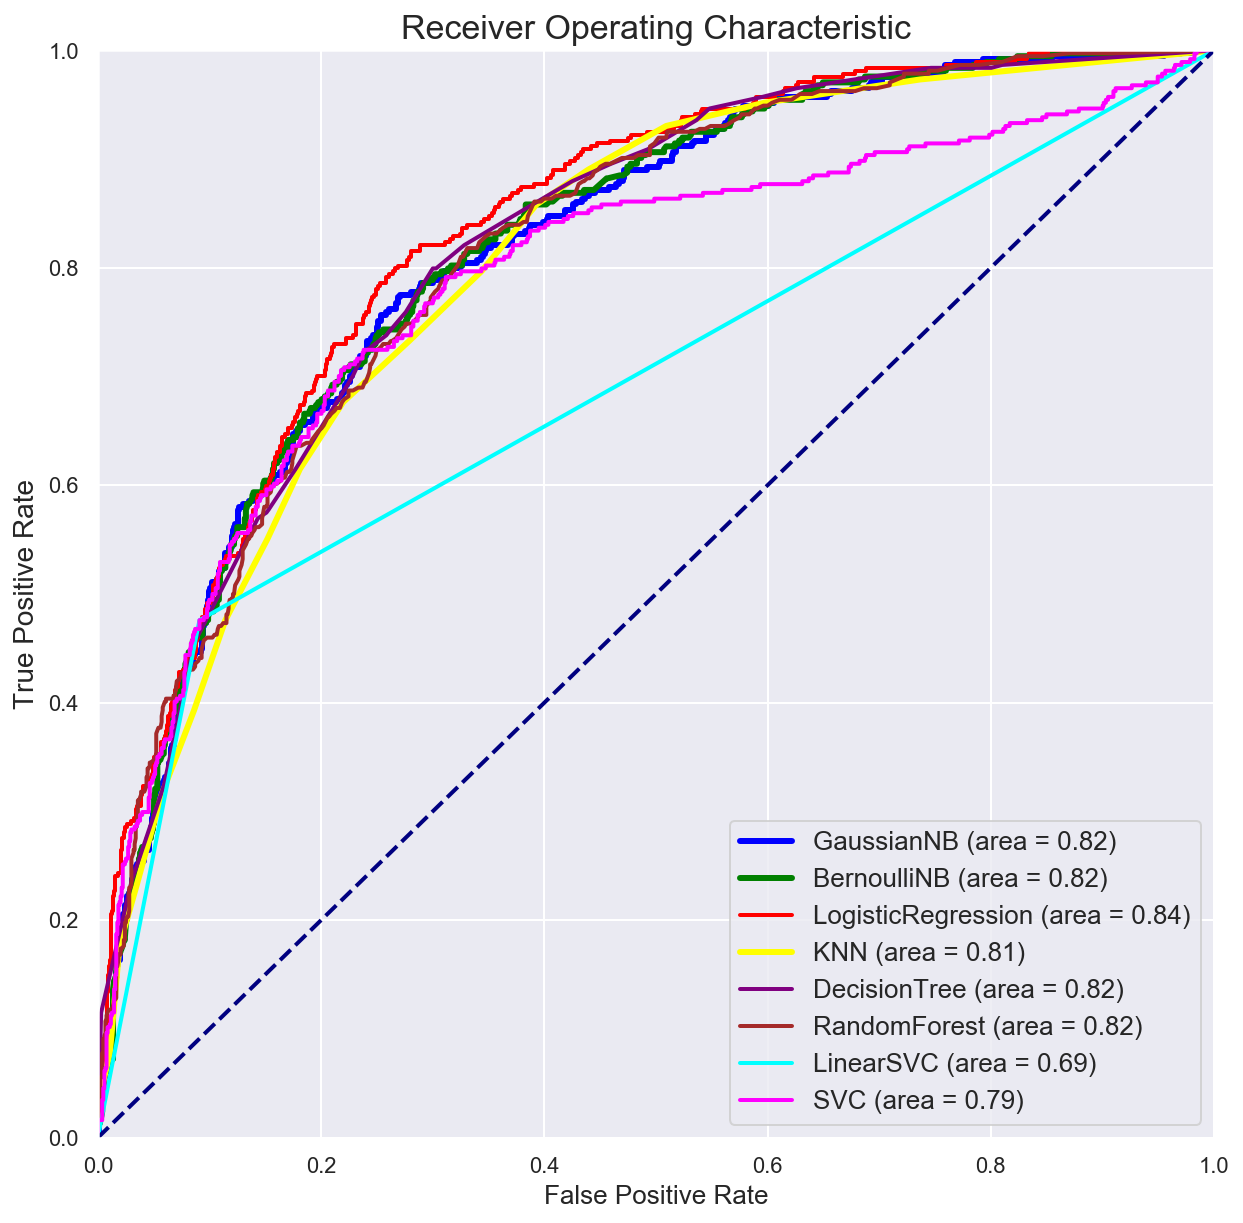

In [138]:
# plot the ROC curves
plt.figure(figsize=(10,10))

y_pred = gnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='blue',
        lw=3, label='GaussianNB (area = %0.2f)' % auc_list[0])

y_pred = bnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='green',
        lw=3, label='BernoulliNB (area = %0.2f)' % auc_list[1])

y_pred = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red',
        lw=2, label='LogisticRegression (area = %0.2f)' % auc_list[2])

y_pred = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='yellow',
        lw=3, label='KNN (area = %0.2f)' % auc_list[3])

y_pred = decisiontree.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='purple',
        lw=2, label='DecisionTree (area = %0.2f)' % auc_list[4])

y_pred = randomforest.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='brown',
        lw=2, label='RandomForest (area = %0.2f)' % auc_list[5])

y_pred = linearsvc.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='cyan',
        lw=2, label='LinearSVC (area = %0.2f)' % auc_list[6])

y_pred = svc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='magenta',
        lw=2, label='SVC (area = %0.2f)' % auc_list[7])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [139]:
# see how logistic regression confusion matrix varies with threshold
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_pred = (logit.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no churn', 'churn'],
           yticklabels=['no churn', 'churn']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
# Let's see how our confusion matrix changes with changes to the cutoff! 
from ipywidgets import interactive, FloatSlider
logit = LogisticRegression(C = optimal_c)
logit.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(logit, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [ ]:
# compare above Confusion Matrix with the Optimal threshold 0.318
# Precision: 0.5812,   Recall: 0.7615,   F1 Score: 0.6593
# LogisticRegression confusion matrix: 
#  [[803 214]
#  [ 93 297]]